<a href="https://colab.research.google.com/github/snowman74/Neural-Networks/blob/main/%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F%203D%20%D1%81%D0%BA%D0%B0%D0%BD%D0%BE%D0%B2%20%D0%BC%D0%BE%D0%B7%D0%B3%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Установка и импорт необходимых библиотек

In [ ]:
pip install SimpleITK

     |████████████████████████████████| 47.4MB 61kB/s 


In [ ]:
import os
import gc
import time
import tensorflow.keras.callbacks
import re
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from PIL import Image
import cv2
from tensorflow.keras import utils
from tensorflow.keras.models import Model # Импортируем модели keras: Model
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization # Импортируем стандартные слои keras
from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
from tensorflow.keras.preprocessing import image # Импортируем модуль image для работы с изображениями
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
import random
from PIL import Image # импортируем модель Image для работы с изображениями
import seaborn as sns
sns.set_style('darkgrid')

drive.mount('/content/drive')

Mounted at /content/drive


## Распаковка и подготовка файлов для дальнейшей работы

In [ ]:
!rm -rf 'Brain_CT_labeling'
!unzip '/content/drive/MyDrive/Базы/Brain_CT_labeling.zip'

Archive:  /content/drive/MyDrive/Базы/Brain_CT_labeling.zip
   creating: Brain_CT_labeling/
  inflating: Brain_CT_labeling/6-seg.nii.gz  
  inflating: Brain_CT_labeling/6.txt  
  inflating: Brain_CT_labeling/7-seg.nii.gz  
  inflating: Brain_CT_labeling/7.txt  
  inflating: Brain_CT_labeling/5.txt  
  inflating: Brain_CT_labeling/7.nii.gz  
  inflating: Brain_CT_labeling/5.nii.gz  
  inflating: Brain_CT_labeling/6.nii.gz  
  inflating: Brain_CT_labeling/5-seg.nii  
  inflating: Brain_CT_labeling/1.txt  
  inflating: Brain_CT_labeling/1-seg.nii.gz  
  inflating: Brain_CT_labeling/4.txt  
  inflating: Brain_CT_labeling/1.nii.gz  
  inflating: Brain_CT_labeling/3.txt  
  inflating: Brain_CT_labeling/4-seg.nii  
  inflating: Brain_CT_labeling/2.txt  
  inflating: Brain_CT_labeling/3.nii.gz  
  inflating: Brain_CT_labeling/3-seg.nii  
  inflating: Brain_CT_labeling/2.nii.gz  
  inflating: Brain_CT_labeling/2-seg.nii.gz  
  inflating: Brain_CT_labeling/Описание.pdf  


In [ ]:
os.listdir('Brain_CT_labeling')

['3-seg.nii',
 '5.txt',
 '1.nii.gz',
 '7-seg.nii.gz',
 '7.txt',
 '4-seg.nii',
 '2.nii.gz',
 '3.txt',
 '1-seg.nii.gz',
 '6.nii.gz',
 '2-seg.nii.gz',
 '6.txt',
 '3.nii.gz',
 '1.txt',
 '5-seg.nii',
 '7.nii.gz',
 '6-seg.nii.gz',
 'Описание.pdf',
 '4.txt',
 '2.txt',
 '5.nii.gz']

**В базе отсутствует исходное изображение 4, в наличии только сегментированное, поэтому исключаем его из базы.** 

**Также файлы 2-seg.nii.gz и 5-seg.nii.gz соответсвуют исходным, а 2.nii.gz и 5.nii.gz - сегментированным, так что переименуем их.** 

**Еще, для удобства, переименуем файл 3-seg.nii в 3-seg.nii.gz**

In [ ]:
os.remove('/content/Brain_CT_labeling/4-seg.nii')

os.rename('/content/Brain_CT_labeling/2.nii.gz', '/content/Brain_CT_labeling/2-seg_.nii.gz')
os.rename('/content/Brain_CT_labeling/5.nii.gz', '/content/Brain_CT_labeling/5-seg_.nii.gz')

os.rename('/content/Brain_CT_labeling/2-seg.nii.gz', '/content/Brain_CT_labeling/2.nii.gz')
os.rename('/content/Brain_CT_labeling/5-seg.nii', '/content/Brain_CT_labeling/5.nii.gz')

os.rename('/content/Brain_CT_labeling/2-seg_.nii.gz', '/content/Brain_CT_labeling/2-seg.nii.gz')
os.rename('/content/Brain_CT_labeling/5-seg_.nii.gz', '/content/Brain_CT_labeling/5-seg.nii.gz')

os.rename('/content/Brain_CT_labeling/3-seg.nii', '/content/Brain_CT_labeling/3-seg.nii.gz')

In [ ]:
os.listdir('Brain_CT_labeling')

['5-seg.nii.gz',
 '4.txt',
 '1.nii.gz',
 '1-seg.nii.gz',
 '5.nii.gz',
 '1.txt',
 '6.nii.gz',
 '6.txt',
 '2.nii.gz',
 '5.txt',
 '7-seg.nii.gz',
 '7.txt',
 '3.txt',
 '3.nii.gz',
 '7.nii.gz',
 '6-seg.nii.gz',
 '3-seg.nii.gz',
 '2-seg.nii.gz',
 'Описание.pdf',
 '2.txt']

## Функции, необходимые для работы

In [ ]:
#### ПОЛЕЗНЫЙ КОЛБЭК СБОРКИ МУСОРА (ОЧИЩАЕТ ОЗУ) ###############
# Custom Callback To Include in Callbacks List At Training Time
# class GarbageCollectorCallback(tensorflow.keras.callbacks.Callback):
#    def on_epoch_end(self, epoch, logs=None):
#        gc.collect()
#### ПОЛЕЗНЫЙ КОЛБЭК СБОРКИ МУСОРА (ОЧИЩАЕТ ОЗУ) ###############

**Так как объем ОЗУ, предоставляемый Google Colaboratories ограничен 12 ГБ на один сеанс, придётся уменьшить размер изображений, поэтому создадим функцию для уменьшения размера изображений**

Остальные функции

In [ ]:
def matrix_from_axis_angle(a):
  """ Вычисление матрицы поворота на заданный угол

  входные параметры:
  a : массив, форма (4,)
      оси поворота и заданный угол
  выход:
  R : массив, форма (3, 3)
      матрица поворота
  """
  ux, uy, uz, theta = a
  c = np.cos(theta)
  s = np.sin(theta)
  ci = 1.0 - c
  R = np.array([[ci * ux * ux + c,
                  ci * ux * uy - uz * s,
                  ci * ux * uz + uy * s],
                [ci * uy * ux + uz * s,
                  ci * uy * uy + c,
                  ci * uy * uz - ux * s],
                [ci * uz * ux - uy * s,
                  ci * uz * uy + ux * s,
                  ci * uz * uz + c],
                ])
  return R


def resample(image, transform):
  """
  Фунция применения указанных трансформаций к изображению
  входные параметры:
    param image: sitk-изображение, которое мы хотим преобразовать
    param transform: Ситк-преобразование (например, изменение размера, поворот и т. д.)
  выход:
    Преобразованое sitk-изображение
  
  """
  reference_image = image
  interpolator = sitk.sitkLinear
  default_value = 0
  return sitk.Resample(image, reference_image, transform,
                        interpolator, default_value)


def get_center(img):
  """
  Функция возвращает центр 3D sitk-изображения
  входные параметры:
    img - sitk-изображение, центр которого необходимо вычислить
  выход:
    центр sitk-изображения
  """
  width, height, depth = img.GetSize()
  return img.TransformIndexToPhysicalPoint((int(np.ceil(width/2)),
                                            int(np.ceil(height/2)),
                                            int(np.ceil(depth/2))))

In [ ]:
def image_3d_transform(image, trans_x, trans_y, trans_z, rot_x, rot_y, rot_z, show=False):
  """
  Эта функция преобразует изображение путем поворота по каждой из осей x, y, z на rot_x, rot_y и rot_z, градусов.
  соответственно, а также выполняет сдвиг по осям x, y, z на trans_x, trans_y, trans_z миллиметров соответсвенно
  
  входные параметры:
    image: sitk-изображение
    trans_x: миллиметры, на которое пользователь хочет, чтобы изображение сдвинулось по оси x.
    trans_y: миллиметры, на которое пользователь хочет, чтобы изображение сдвинулось по оси y.
    trans_z: миллиметры, на которое пользователь хочет, чтобы изображение сдвинулось по оси z.

    rot_x: Количество градусов, на которое необходимо повернуть изображение вокруг оси x
    rot_y: Количество градусов, на которое необходимо повернуть изображение вокруг оси y
    rot_z: Количество градусов, на которое необходимо повернуть изображение вокруг оси z
 
    show: булевый параметр, отвечающий за демонстрацию результатов преобразования
  выход: 
    преобразованное sitk-изображение
  """
  rotation_center = (0, 0, 0)
  axis = (0,0,1)
  angle = 0
  translation = (trans_x, trans_y, trans_z)
  scale_factor = 1
  similarity = sitk.Similarity3DTransform(scale_factor, axis, angle, translation, rotation_center)

  affine = sitk.AffineTransform(3)
  image_center = get_center(image)
  affine.SetMatrix(similarity.GetMatrix())
  affine.SetTranslation(similarity.GetTranslation())
  affine.SetCenter(image_center)
  image_var = resample(image, affine)

  rot_x = np.deg2rad(rot_x)
  rot_y = np.deg2rad(rot_y)
  rot_z = np.deg2rad(rot_z)
  euler_transform = sitk.Euler3DTransform(get_center(image_var), rot_x, rot_y, rot_z, (0, 0, 0))
  image_center = get_center(image_var)
  euler_transform.SetCenter(image_center)
  euler_transform.SetRotation(rot_x, rot_y, rot_z)
  resampled_image = resample(image_var, euler_transform)
  if show:
      slice_num = int(input("Enter the index of the slice you would like to see "))
      plt.imshow(sitk.GetArrayFromImage(resampled_image)[slice_num])
      plt.show()
  return resampled_image


In [ ]:
def plot_image(image_array, slice_num=58):
  """
  Функция отрисовки слоя 3D изображения,
  входные параметры:
    image_array: - 3D массив numpy
    slice_num: - необязательный параметр, номер слоя, который требуется отрисовать
  """
  plt.imshow(image_array[slice_num])
  plt.show()

def get_image_from_file(filepath, rescale_param=255):
  """
  Функция получения изображения из файла
  входные параметры:
    filepath - путь к файлу формата .nii или .nii.gz
    rescale_param - по умолчанию задан 255 
                    (в привычном 8-битной цветовой модели RGB),
                    параметр отвечает за масштаб интенсивности цвета
  выход: изображение в формате SimpleITK 
  """
  max_int_val = rescale_param
  image = sitk.ReadImage(filepath, sitk.sitkFloat32)
  image = sitk.RescaleIntensity(image,0.0,max_int_val)
  return image

def check_correct(img_array_1, img_array_2):
  """
  Функция для отрисовки наложенных друг на друга изображений, чтобы проверить
  ориентацию сегментированных и оригинальных изображений
  входные параметры:
    img_array_1, img_array_2 - 2D numpy массивы 
  
  """
  img_1 = Image.fromarray(img_arr_1).convert('RGB')
  img_2 = Image.fromarray(img_arr_2).convert('RGB')

  w, h = img_1.size
  
  for x in range(w):
      for y in range(h):
          pix_coord = (x, y)
          r, g, b = img_1.getpixel(pix_coord)
          r1, g1, b1 = img_2.getpixel(pix_coord)
          new_col = (int(0.5 * r + 0.5 * r1), int(0.5 * g + 0.5 * g1), int(0.5 * b + 0.5 * b1))
          img_1.putpixel(pix_coord, new_col)
  plt.figure(figsize=(5,5))
  plt.imshow(img_1)

In [ ]:
def color_2_OHE(y_train_no_OHE, num_classes=21):
  """
  Функция формирования y_train в формате one-hot-encoding
  входные параметры:
    y_train_no_OHE - сегментированное изображение (numpy 3D массив в котором в 
    качестве значений интенсивности пикселя закодирован требуемый класс)

    num_classes=21 - int, целевое число классов сегментации

  выход:
    numpy 3D массив в котором вместо значений интенсивности пикселя закодирован 
    требуемый класс в формате one-hot-encoding
  """
  y_train = [] # Целевой массив
  init_shape = y_train_no_OHE.shape # сохраним входную форму для финального reshape
  for i in range(y_train_no_OHE.shape[0]): # проходимся по всем слоям (по всей оси Z)
    var_array = y_train_no_OHE[i].copy() # для удобства создадим переменную-массив 
    var_array = var_array.reshape(img_height * img_width, 1) # развернем её в двумерный массив
    out_array = [] # выходной массив (один слой по оси Z в формате one-hot-encoding)
    for j in range(var_array.size): # проходимся по всей длине двумерного массива
      out_array.append(utils.to_categorical(var_array[j, 0], num_classes)) # добавляем 
                                                                  # в выходной массив номер класса в формате one-hot-encoding

    y_train.append(out_array) # добавляем в целевой массив весь слой целиком
    if len(y_train) % 25 == 0: print(f"""Сформированно {len(y_train)} из {y_train_no_OHE.shape[0]} слоёв \t осталось: {y_train_no_OHE.shape[0] - len(y_train)}""")

  y_train = np.array(y_train) # преобразуем в numpy
  # возвращаем в формате (ЧИСЛО_СЛОЕВ_Z * ШИРИНА * ДЛИНА * (РАЗМЕР ВЕКТОРА O-H-E))
  return y_train.reshape(init_shape[0], init_shape[1], init_shape[2], num_classes) 


In [ ]:
def up_contrast_sharpness(array_3d, show=False): 
  """
  Функция увеличения резкости изображения и повышения контраста
  входные параметры:
    array_3d - 3D numpy массив изображения, которое необходимо обработать 
    show=False - bool, флаг, отвечающий за демонстрацию результирующего изображения
  выход:
    массив numpy (изображение с увеличенной резкостью и контрастом)
  """
  kernel = np.array([[0, -1, 0],
                    [-1, 5, -1],
                    [0, -1, 0]])
  result = []
  for i in range(array_3d.shape[0]):
  # Создадим ядро для выделения пикселей
    image = array_3d[i]
    # Увеличим резкость изображения
    image_sharp = cv2.filter2D(np.uint8(image), -1, kernel)
    # увеличим контраст изображения
    image_enhanced = cv2.equalizeHist(image_sharp)
    result.append(image_enhanced)
    # Показать изображение, если флаг show задан True
    if show:
      plt.imshow(image_enhanced, cmap="gray")
      plt.show()
  return np.array(result, dtype='float32')

In [ ]:
def resize_image(img_3d_array, img_width, img_height):
  """
  Функция изменения размера изображений по оси Z
  входные параметры:
    img_3d_array - массив numpy с размерностью = 3 (Например: img_3d_array.shape = (422,512,512))
    img_width, img_height - int, размеры требуемого массива
  
  выход: 
    numpy массив, изображение, требуемого размера
  """
  result = []
  for i in range(img_3d_array.shape[0]):
    image = img_3d_array[i]
    img = Image.fromarray(np.float32(image)).convert('RGB')
    gray = cv2.cvtColor(np.float32(img), cv2.COLOR_BGR2GRAY)
    resized_image = cv2.resize(gray, dsize=(img_height, img_width), interpolation=cv2.INTER_LINEAR)
    result.append(resized_image)
  return np.array(result, dtype='float32')

In [ ]:
def index2color(index2):
  """
  Функция преобразования индекса в цвет пикселя
  (для более четкого разделения классов, отобразим номера классов в диапазон от 0 до 255)
  входные параметры:
    index2 - класс изображения, предсказанный сетью (формой num_classes, значения вероятности предсказанного класса)
  выход:
    color - цвет, соответсвующий классу
  """
  index = np.argmax(index2) # Получаем индекс максимального элемента
  color=[]
  if index == 0: color = [0*255/21]
  elif index == 1: color = [1*255/21] 
  elif index == 2: color = [2*255/21] 
  elif index == 3: color = [3*255/21] 
  elif index == 4: color = [4*255/21] 
  elif index == 5: color = [5*255/21] 
  elif index == 6: color = [6*255/21] 
  elif index == 7: color = [7*255/21] 
  elif index == 8: color = [8*255/21] 
  elif index == 9: color = [9*255/21] 
  elif index == 10: color = [10*255/21] 
  elif index == 11: color = [11*255/21] 
  elif index == 12: color = [12*255/21] 
  elif index == 13: color = [13*255/21] 
  elif index == 14: color = [14*255/21] 
  elif index == 15: color = [15*255/21] 
  elif index == 16: color = [16*255/21]
  elif index == 17: color = [17*255/21] 
  elif index == 18: color = [18*255/21] 
  elif index == 19: color = [19*255/21] 
  elif index == 20: color = [20*255/21] 
  elif index == 21: color = [21*255/21] 
   
  return color # Возвращаем цвет пикслея

In [ ]:
def processImage(model, count=1, num_classes=21):
  """
  Функция визуализации сегментированных изображений
  входные параметры:
    model - обученная модель нейросети
    count - число случайных индексов
    num_classes - число классов сегментации 
  """
  indexes = np.random.randint(0, len(x_val), count) # Получаем count случайных индексов
  fig, axs = plt.subplots(3, count, figsize=(25, 15)) #Создаем полотно из n графиков
  for i,idx in enumerate(indexes): # Проходим по всем сгенерированным индексам
    predict = np.array(model.predict(x_val[idx].reshape(1, img_width, img_height, 1))) # Предиктим картику
    pr = predict[0] # Берем нулевой элемент из перидкта
    pr1 = [] # Пустой лист под сегментированную картинку из predicta
    pr2 = [] # Пустой лист под сегменитрованную картинку из yVal
    pr = pr.reshape(-1, num_classes) # Решейпим предикт
    yr = y_val[idx].reshape(-1, num_classes) # Решейпим yVal
    for k in range(len(pr)): # Проходим по всем уровням (количесвто классов)
      pr1.append(index2color(pr[k])) # Переводим индекс в писксель
      pr2.append(index2color(yr[k])) # Переводим индекс в писксель
    pr1 = np.array(pr1) # Преобразуем в numpy
    pr1 = pr1.reshape(img_width, img_height,1) # Решейпим к размеру изображения
    pr2 = np.array(pr2) # Преобразуем в numpy
    pr2 = pr2.reshape(img_width, img_height,1) # Решейпим к размеру изображения
    img = Image.fromarray(np.squeeze(pr1, axis=2).astype(np.uint8)) # Получаем картику из предикта
    axs[0,i].imshow(img.convert('RGBA')) # Отображаем на графике в первой линии
    axs[0,i].axis('off')
    axs[1,i].imshow(Image.fromarray(np.squeeze(pr2, axis=2).astype('uint8'))) # Отображаем на графике во второй линии сегментированное изображение из yVal
    axs[1,i].axis('off')
    axs[2,i].imshow(Image.fromarray(np.squeeze(x_val[idx], axis=2).astype('uint8'))) # Отображаем на графике в третьей линии оригинальное изображение        
    axs[2,i].axis('off')
  plt.show()  

In [ ]:
def dice_coef(y_true, y_pred):
  '''
  Функция метрики, обрабатывающая пересечение двух областей
  '''
  return (2 * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) # Возвращаем площадь пересечения деленную на площадь объединения двух областей

In [ ]:
def processImage(model, x_to_predict, y_to_predict, start, stop, num_classes=21):
  """
  Функция визуализации сегментированных изображений
  входные параметры:
    model - обученная модель нейросети
    start - номер первого индекса
    stop - номер последнего индекса
    count - число индексов
    num_classes - число классов сегментации 
  """
  count = stop - start
  indexes = np.linspace(start, stop, count).astype('uint8') # Получаем count случайных индексов
  fig, axs = plt.subplots(3, count, figsize=(25, 15)) #Создаем полотно из n графиков
  for i,idx in enumerate(indexes): # Проходим по всем сгенерированным индексам
    predict = np.array(model.predict(x_to_predict[idx].reshape(1, img_width, img_height, 1))) # Предиктим картику
    pr = predict[0] # Берем нулевой элемент из предикта
    pr1 = [] # Пустой лист под сегментированную картинку из предикта
    pr2 = [] # Пустой лист под сегменитрованную картинку из y_to_predict
    pr = pr.reshape(-1, num_classes) # Решейпим предикт
    yr = y_to_predict[idx].reshape(-1, num_classes) # Решейпим y_to_predict
    for k in range(len(pr)): # Проходим по всем уровням (количество классов)
      pr1.append(index2color(pr[k])) # Переводим индекс в писксель
      pr2.append(index2color(yr[k])) # Переводим индекс в писксель
    pr1 = np.array(pr1) # Преобразуем в numpy
    pr1 = pr1.reshape(img_width, img_height,1) # Решейпим к размеру изображения
    pr2 = np.array(pr2) # Преобразуем в numpy
    pr2 = pr2.reshape(img_width, img_height,1) # Решейпим к размеру изображения
    img = Image.fromarray(np.squeeze(pr1, axis=2).astype(np.uint8)) # Получаем картику из предикта
    axs[0,i].imshow(img.convert('RGBA')) # Отображаем на графике в первой линии
    axs[0,i].axis('off')
    axs[1,i].imshow(Image.fromarray(np.squeeze(pr2, axis=2).astype('uint8'))) # Отображаем на графике во второй линии сегментированное изображение из yVal
    axs[1,i].axis('off')
    axs[2,i].imshow(Image.fromarray(np.squeeze(x_to_predict[idx], axis=2).astype('uint8'))) # Отображаем на графике в третьей линии оригинальное изображение        
    axs[2,i].axis('off')
  plt.show()  

In [ ]:
def index_to_20_color(index2):
  """
  Функция преобразования индекса в цвет пикселя
  (теперь уже в диапазон как на входных массивах)
  """
  index = np.argmax(index2) # Получаем индекс максимального элемента
  color=[]
  if index == 0: color = [0]
  elif index == 1: color = [1] 
  elif index == 2: color = [2] 
  elif index == 3: color = [3] 
  elif index == 4: color = [4] 
  elif index == 5: color = [5] 
  elif index == 6: color = [6] 
  elif index == 7: color = [7] 
  elif index == 8: color = [8] 
  elif index == 9: color = [9] 
  elif index == 10: color = [10] 
  elif index == 11: color = [11] 
  elif index == 12: color = [12] 
  elif index == 13: color = [13] 
  elif index == 14: color = [14] 
  elif index == 15: color = [15] 
  elif index == 16: color = [16]
  elif index == 17: color = [17] 
  elif index == 18: color = [18] 
  elif index == 19: color = [19] 
  elif index == 20: color = [20] 
  elif index == 21: color = [21] 
   
  return color # Возвращаем цвет пикслея

In [ ]:
def get_final_array(list_images, first_image, last_image, uint_flag=False):
  """
  функция получения массивов для обучения сети из списка изображений
  входные параметры:
    list_images - список изображений
    first_image - индекс первого изображения для выборки
    last_image - индекс последнего изображения для выборки
  выход - массив для обучения сети
  """
  final_array = []
  for i in range(first_image, last_image + 1):
    for layer in range(list_images[i].shape[0]):
        final_array.append(list_images[i][layer].reshape((img_height, img_width, 1)))
  if uint_flag:
    final_array = np.array(final_array, dtype='uint8')
  else:
    final_array = np.array(final_array)
  print('Форма полученного массива = ', final_array.shape)
  return final_array

In [ ]:
def get_sitk_image(model, array, first_layer, last_layer, filepath):
  """
  Функция получения и сохранения sitk изображения из массивов
  входные параметры:
    model - модель сети, формирующая predict
    array - массив, из которого нужно собрать изображение
    first_layer - индекс первого слоя
    last_layer - индекс последнего слоя,
    filepath - путь для сохранения файла
  выход:
    sitk изображение
  """
  predict = []
  # пройдемся по первой оси массива (слоям будущего 3D изображения)
  for i in range(first_layer, last_layer):
    predict.append(model.predict(array[i].reshape(1, img_width, img_height, 1)))
  predict = np.array(predict)
  predict = predict.reshape(last_layer, 192, 192, 21)
  # по слоям прошлись, теперь пройдем по оси с one-hot-encoding-представлением и преобразуем обратно в пиксели
  pr = predict.reshape(-1, num_classes)
  final_image = []
  for i in range(len(pr)):
    final_image.append(index_to_20_color(pr[i]))
  # преобразуем в numpy
  final_image = np.array(final_image)
  # приведем к финальному размеру
  final_image = final_image.reshape(predict.shape[0], img_width, img_height) 
  # увеличим до исходных размеров
  final_image = resize_image(final_image, 512, 512)
  # получим sitk-изображение
  final_image = sitk.GetImageFromArray(final_image)
  # и сохраним его по указанному пути
  sitk.WriteImage(final_image, filepath)
  return final_image # на всякий случай попросим функцию его вернуть

In [ ]:
def get_sitk_image(model, array, first_layer, last_layer, filepath):
  """
  Функция получения и сохранения sitk изображения из массивов
  входные параметры:
    model - модель сети, формирующая predict
    array - массив, из которого нужно собрать изображение
    first_layer - индекс первого слоя
    last_layer - индекс последнего слоя,
    filepath - путь для сохранения файла
  выход:
    sitk изображение
  """
  predict = []
  # пройдемся по первой оси массива (слоям будущего 3D изображения)
  for i in range(first_layer, last_layer):
    predict.append(model.predict(array[i].reshape(1, img_width, img_height, 1)))
  predict = np.array(predict)
  predict = predict.reshape(last_layer - first_layer, 192, 192, 21)
  # по слоям прошлись, теперь пройдем по оси с one-hot-encoding-представлением и преобразуем обратно в пиксели
  pr = predict.reshape(-1, num_classes)
  final_image = []
  for i in range(len(pr)):
    final_image.append(index_to_20_color(pr[i]))
  # преобразуем в numpy
  final_image = np.array(final_image)
  # приведем к финальному размеру
  final_image = final_image.reshape(predict.shape[0], img_width, img_height) 
  # увеличим до исходных размеров
  final_image = resize_image(final_image, 512, 512)
  # получим sitk-изображение
  final_image = sitk.GetImageFromArray(final_image)
  # и сохраним его по указанному пути
  sitk.WriteImage(final_image, filepath)
  return final_image # на всякий случай попросим функцию его вернуть

## Чтение файлов, получение и трансформация изображений  

In [ ]:
# создадим списки файлов сегментированных и исходных изображений
segment_files_list = []
orig_files_list = []
for f in os.listdir('Brain_CT_labeling'):

  if re.search(r'seg.nii.gz', f) != None:
    segment_files_list.append(f)
  else:
    if re.search(r'.nii.gz', f) != None:
      orig_files_list.append(f)

segment_files_list.sort()
orig_files_list.sort()

In [ ]:
# проверим, совпадают ли исходные и сегментированные изображения при наложении
for i in range(len(orig_files_list)): 
  img_1 = get_image_from_file('/content/Brain_CT_labeling/' + orig_files_list[i])
  img_2 = get_image_from_file('/content/Brain_CT_labeling/' + segment_files_list[i])
  img_arr_1 = sitk.GetArrayFromImage(img_1)[58]
  img_arr_2 = sitk.GetArrayFromImage(img_2)[58]
  check_correct(img_arr_1, img_arr_2)    

**Видим, что при наложении, сегментированное изображение не совпадает с оригинальным, а значит требуется трансформация оригинальных изображений, аналогично тому, как мы это делали в программе ITK-SNAP**

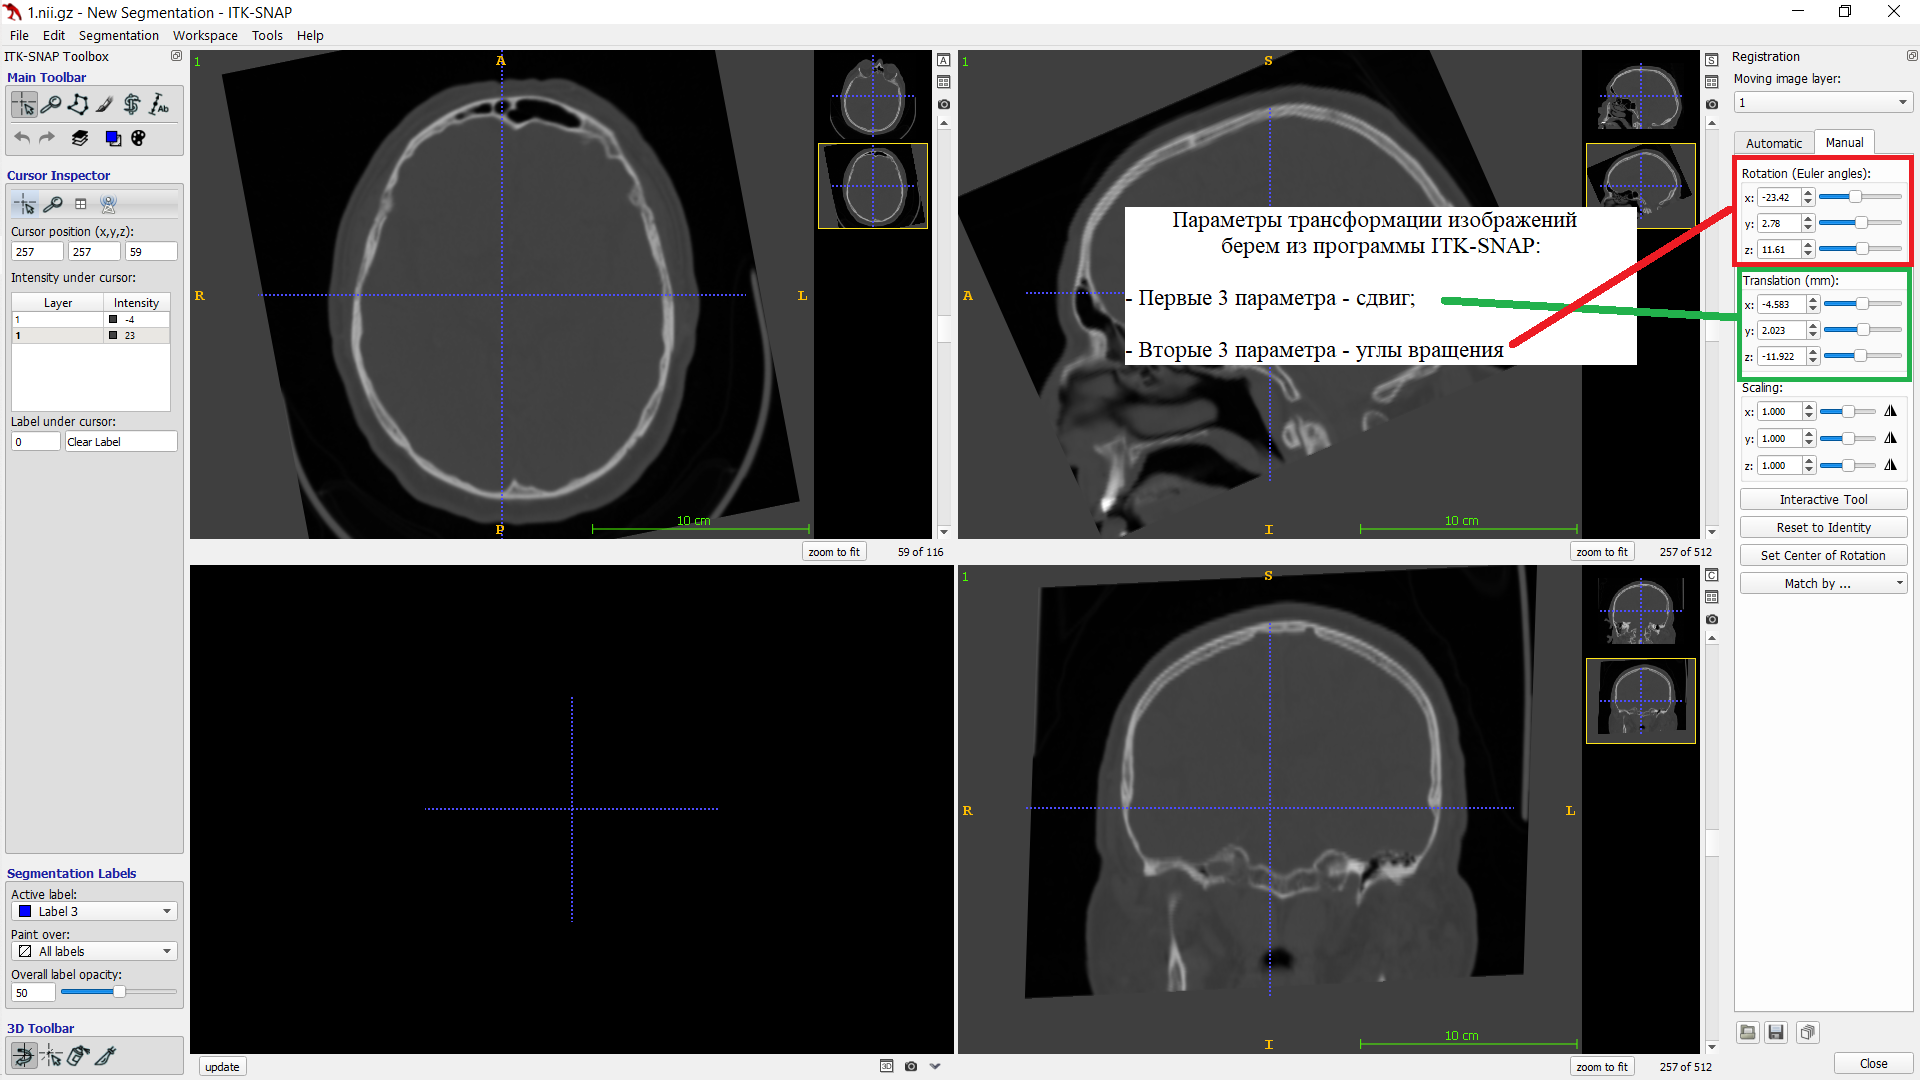

*Создадим список параметров для трансформации исходных изображений*

In [ ]:
# список с параметрами трансформации для изображений 1, 2, 3, 5, 6, 7 соответственно
params_list = [[-4.583, 2.023, -11.922, -23.42, 2.78, 11.61], 
               [19.625, 1.961, -0.459, -6.17, 2.45, -4.58], 
               [5.579, 6.564, -5.920, -13.91, -0.29, -11.95], 
               [0.026, 6.626, 2.264, -12.09, -1.50, 0.02], 
               [3.398, -0.382, 4.807, 0.48, 1.00, -5.47], 
               [15.004, 10.973, -3.521, -12.91, 4.42, -6.74]]

In [ ]:
# для удобства создадим папку для трансформированных изображений
os.mkdir('/content/Brain_CT_labeling/transform_images')
# применим преобразования и сохраним полученные изображения
for i in range(len(params_list)):
  trans_x, trans_y, trans_z, rot_x, rot_y, rot_z = params_list[i]
  orig_image = get_image_from_file('/content/Brain_CT_labeling/' + orig_files_list[i])
  transform_image = image_3d_transform(orig_image, trans_x, trans_y, trans_z, rot_x, rot_y, rot_z)
  sitk.WriteImage(transform_image, f'/content/Brain_CT_labeling/transform_images/{orig_files_list[i][0]}-transform.nii.gz')

In [ ]:
# создадим список трансформированных файлов
transform_files_list = []
for f in os.listdir('Brain_CT_labeling/transform_images'):
  transform_files_list.append(f)
transform_files_list.sort()

**Теперь проверим как сработали наши преобразования**

In [ ]:
# воспользуемся нашей функцией check_correct
for i in range(len(segment_files_list)): 
  img_1 = get_image_from_file('/content/Brain_CT_labeling/transform_images/' + transform_files_list[i])
  img_2 = get_image_from_file('/content/Brain_CT_labeling/' + segment_files_list[i], rescale_param=512)
  img_arr_1 = sitk.GetArrayFromImage(img_1)[58]
  img_arr_2 = sitk.GetArrayFromImage(img_2)[58]
  check_correct(img_arr_1, img_arr_2)    

**Видим, что изображения совпадают, можно приступать к предобработке**

## Предобработка изображений

In [ ]:
# ГЛОБАЛЬНЫЕ ПАРАМЕТРЫ:
img_width =  192# Ширина уменьшенной картинки 
img_height = 192  # Высота уменьшенной картинки 
num_classes = 21 # Задаем количество классов на изображении (21 - с учётом неразмеченного фона)

In [ ]:
# применим функцию получения numpy массивов из изображений nii
trans_images_arrs_list = []
seg_images_arrs_list = []
for f in range(len(transform_files_list)):
  tr_file_var = get_image_from_file('/content/Brain_CT_labeling/transform_images/' + transform_files_list[f])
  seg_file_var = get_image_from_file('/content/Brain_CT_labeling/' + segment_files_list[f], rescale_param=20)
  trans_images_arrs_list.append(sitk.GetArrayFromImage(tr_file_var))
  seg_images_arrs_list.append(sitk.GetArrayFromImage(seg_file_var))
  print('Массив изображения ', transform_files_list[f], ' добавлен, форма массива = ', sitk.GetArrayFromImage(tr_file_var).shape)
  print('Массив изображения ', segment_files_list[f], '   добавлен, форма массива = ', sitk.GetArrayFromImage(seg_file_var).shape)

Массив изображения  1-transform.nii.gz  добавлен, форма массива =  (116, 512, 512)
Массив изображения  1-seg.nii.gz    добавлен, форма массива =  (116, 512, 512)
Массив изображения  2-transform.nii.gz  добавлен, форма массива =  (98, 512, 512)
Массив изображения  2-seg.nii.gz    добавлен, форма массива =  (98, 512, 512)
Массив изображения  3-transform.nii.gz  добавлен, форма массива =  (104, 512, 512)
Массив изображения  3-seg.nii.gz    добавлен, форма массива =  (104, 512, 512)
Массив изображения  5-transform.nii.gz  добавлен, форма массива =  (104, 512, 512)
Массив изображения  5-seg.nii.gz    добавлен, форма массива =  (104, 512, 512)
Массив изображения  6-transform.nii.gz  добавлен, форма массива =  (106, 512, 512)
Массив изображения  6-seg.nii.gz    добавлен, форма массива =  (106, 512, 512)
Массив изображения  7-transform.nii.gz  добавлен, форма массива =  (102, 512, 512)
Массив изображения  7-seg.nii.gz    добавлен, форма массива =  (102, 512, 512)


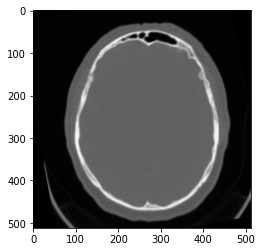

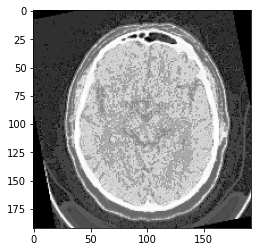

In [ ]:
test = up_contrast_sharpness(trans_images_arrs_list[0], show=False)
test = resize_image(test, img_width, img_height)
# посмотрим на результат
plt.imshow(trans_images_arrs_list[0][58], cmap="gray")
plt.show()
plt.imshow(test[58], cmap="gray")
plt.show()

In [ ]:
# применим преобразования ко всем изображениям
prepared_orig_images = []
for i in range(len(trans_images_arrs_list)):
  image = up_contrast_sharpness(trans_images_arrs_list[i]) # применяем преобразования
  image = resize_image(image, img_width, img_height)
  prepared_orig_images.append(image)

In [ ]:
prepared_seg_images = []
for i in range(len(seg_images_arrs_list)):
  image = seg_images_arrs_list[i] # применяем преобразования
  image = resize_image(image, img_width, img_height)
  image = np.uint8(image) # избавляемся от дробных чисел в сегментированном изображении
  prepared_seg_images.append(image)

## Создание x_train y_train, x_val y_val  

в обучающую выборку пойдут 4 изображения, 

в проверочную выборку - 2

In [ ]:
# предварительно разобьем каждое изображение послойно вдоль оси Z, то есть 
# например из первого 3d изображения размером 116 * img_height * img_width 
# получим 116 изображений размером img_height * img_width * 1

x_train = get_final_array(prepared_orig_images, 0, 3)
x_val = get_final_array(prepared_orig_images, 4, 5)

Форма полученного массива =  (422, 192, 192, 1)
Форма полученного массива =  (208, 192, 192, 1)


In [ ]:
np.save('/content/drive/MyDrive/Brain_CT_labeling/x_train.npy', x_train)
np.save('/content/drive/MyDrive/Brain_CT_labeling/x_val.npy', x_val)

In [ ]:
# в таком же соотношении создадим y_train и y_val
y_train_no_OHE = get_final_array(prepared_seg_images, 0, 3, uint_flag=True)
y_val_no_OHE = get_final_array(prepared_seg_images, 4, 5, uint_flag=True)

Форма полученного массива =  (422, 192, 192, 1)
Форма полученного массива =  (208, 192, 192, 1)


In [ ]:
# теперь преобразуем y_train и y_val в формат One-hot-encoding
cur_time = time.time()
y_train = color_2_OHE(y_train_no_OHE)
print('Затраченное время ', round((time.time()- cur_time), 1), ' секунд')
np.save('/content/drive/MyDrive/Brain_CT_labeling/y_train.npy', y_train)

Сформированно 25 из 422 слоёв 	 осталось: 397
Сформированно 50 из 422 слоёв 	 осталось: 372
Сформированно 75 из 422 слоёв 	 осталось: 347
Сформированно 100 из 422 слоёв 	 осталось: 322
Сформированно 125 из 422 слоёв 	 осталось: 297
Сформированно 150 из 422 слоёв 	 осталось: 272
Сформированно 175 из 422 слоёв 	 осталось: 247
Сформированно 200 из 422 слоёв 	 осталось: 222
Сформированно 225 из 422 слоёв 	 осталось: 197
Сформированно 250 из 422 слоёв 	 осталось: 172
Сформированно 275 из 422 слоёв 	 осталось: 147
Сформированно 300 из 422 слоёв 	 осталось: 122
Сформированно 325 из 422 слоёв 	 осталось: 97
Сформированно 350 из 422 слоёв 	 осталось: 72
Сформированно 375 из 422 слоёв 	 осталось: 47
Сформированно 400 из 422 слоёв 	 осталось: 22
Затраченное время  103.1  секунд


In [ ]:
cur_time = time.time()
y_val = color_2_OHE(y_val_no_OHE)
print('Затраченное время ', round((time.time()- cur_time), 1), ' секунд')
np.save('/content/drive/MyDrive/Brain_CT_labeling/y_val.npy', y_val)

Сформированно 25 из 208 слоёв 	 осталось: 183
Сформированно 50 из 208 слоёв 	 осталось: 158
Сформированно 75 из 208 слоёв 	 осталось: 133
Сформированно 100 из 208 слоёв 	 осталось: 108
Сформированно 125 из 208 слоёв 	 осталось: 83
Сформированно 150 из 208 слоёв 	 осталось: 58
Сформированно 175 из 208 слоёв 	 осталось: 33
Сформированно 200 из 208 слоёв 	 осталось: 8
Затраченное время  52.3  секунд


### Подгружаем созданные массивы

In [ ]:
x_train = np.load('/content/drive/MyDrive/Brain_CT_labeling/x_train.npy')
x_val = np.load('/content/drive/MyDrive/Brain_CT_labeling/x_val.npy')

y_train = np.load('/content/drive/MyDrive/Brain_CT_labeling/y_train.npy')
y_val = np.load('/content/drive/MyDrive/Brain_CT_labeling/y_val.npy')

## Нейросети

In [ ]:
# ГЛОБАЛЬНЫЕ ПАРАМЕТРЫ:
img_width =  192# Ширина уменьшенной картинки 
img_height = 192  # Высота уменьшенной картинки 
num_classes = 21 # Задаем количество классов на изображении (21 - с учётом неразмеченного фона)

### Линейная сегментирующая сеть

In [ ]:
def linearSegmentationNet(num_classes, input_shape):
  '''
  Функция создания линейной сегментирующей сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
  '''
  img_input = Input(input_shape)                                          # Создаем входной слой с размерностью input_shape
  x = Conv2D(128, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 128-нейронами
  x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
  x = Activation('relu')(x)                                               # Добавляем слой Activation

  x = Conv2D(128, (3, 3), padding='same', name='block1_conv2')(x)         # Добавляем Conv2D-слой с 128-нейронами
  x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
  x = Activation('relu')(x)                                               # Добавляем слой Activation

  x = Conv2D(num_classes,(3, 3), activation='softmax', padding='same')(x) # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

  model = Model(img_input, x)                                             # Создаем модель с входом 'img_input' и выходом 'x'

  # Компилируем модель
  model.compile(optimizer=Adam(lr=1e-3),
                loss='categorical_crossentropy',
                metrics=[dice_coef])
  return model # Возвращаем сформированную модель

In [ ]:
modelL = linearSegmentationNet(num_classes, (img_width, img_height, 1)) # Создаем моель linearSegmentationNet
modelL.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 192, 192, 1)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 192, 192, 128)     1280      
_________________________________________________________________
batch_normalization_38 (Batc (None, 192, 192, 128)     512       
_________________________________________________________________
activation_38 (Activation)   (None, 192, 192, 128)     0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 192, 192, 128)     147584    
_________________________________________________________________
batch_normalization_39 (Batc (None, 192, 192, 128)     512       
_________________________________________________________________
activation_39 (Activation)   (None, 192, 192, 128)     0   

In [ ]:
modelL = linearSegmentationNet(num_classes, (img_width, img_height, 1)) # Создаем моель linearSegmentationNet
history = modelL.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val), verbose=1) # Обучаем модель на выборке по трем классам

Epoch 1/10
14/14 [==============================] - 10s 518ms/step - loss: 1.3599 - dice_coef: 0.2386 - val_loss: 1.1888 - val_dice_coef: 0.4694
Epoch 2/10
14/14 [==============================] - 6s 402ms/step - loss: 0.2695 - dice_coef: 0.4609 - val_loss: 0.7937 - val_dice_coef: 0.4452
Epoch 3/10
14/14 [==============================] - 6s 406ms/step - loss: 0.2427 - dice_coef: 0.4611 - val_loss: 0.6883 - val_dice_coef: 0.4294
Epoch 4/10
14/14 [==============================] - 6s 411ms/step - loss: 0.2455 - dice_coef: 0.4582 - val_loss: 0.5517 - val_dice_coef: 0.4417
Epoch 5/10
14/14 [==============================] - 6s 416ms/step - loss: 0.2632 - dice_coef: 0.4554 - val_loss: 0.5104 - val_dice_coef: 0.4587
Epoch 6/10
14/14 [==============================] - 6s 422ms/step - loss: 0.2306 - dice_coef: 0.4604 - val_loss: 0.4683 - val_dice_coef: 0.4139
Epoch 7/10
14/14 [==============================] - 6s 415ms/step - loss: 0.2522 - dice_coef: 0.4549 - val_loss: 0.4327 - val_dice_coef

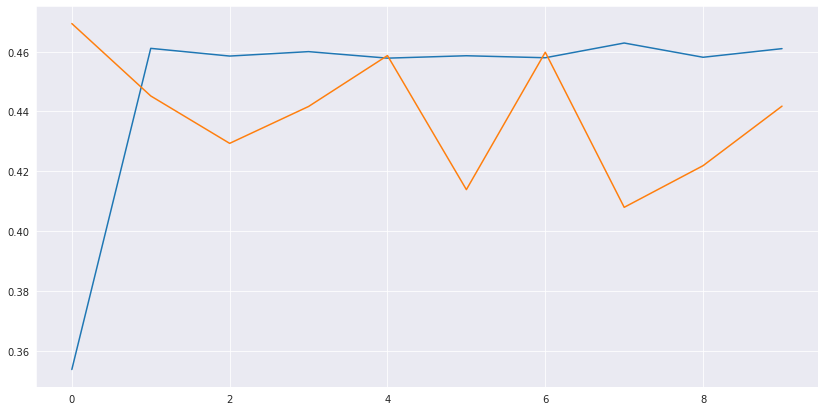

In [ ]:
# Отобразим график обучения модели
plt.figure(figsize=(14,7))
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.show()

In [ ]:
# modelL.save_weights('/content/drive/MyDrive/Brain_CT_labeling/modelL.h5')

In [ ]:
modelL = linearSegmentationNet(num_classes, (img_width, img_height, 1)) # Создаем моель linearSegmentationNet
modelL.load_weights('/content/drive/MyDrive/Brain_CT_labeling/modelL.h5')

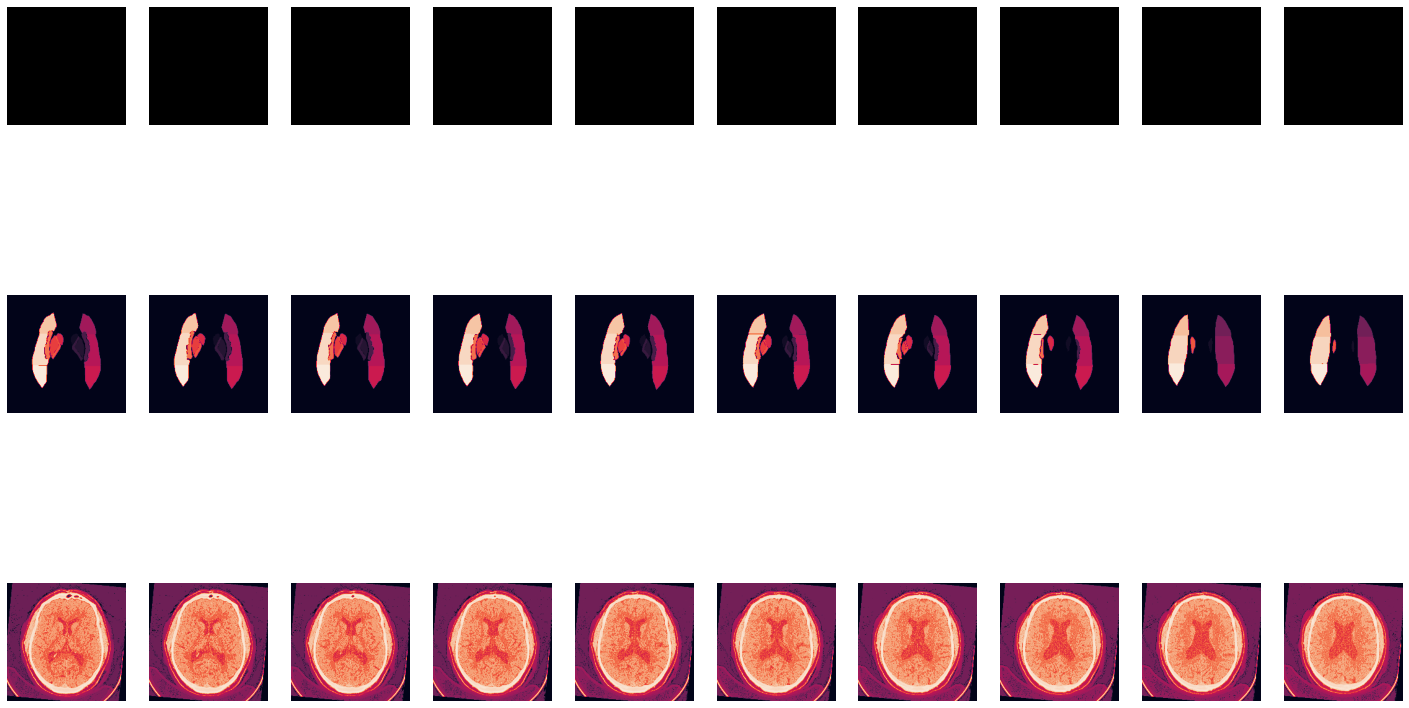

In [ ]:
processImage(modelL, x_val, 50, 60, 10, num_classes)

Можно, конечно, попытаться увеличить точность, поиграть с гиперпараметрами, но вряд ли удастся добиться высоких результатов, поэтому перейдем к архитектуре Unet 

### Unet

In [ ]:
def unet(num_classes=21, input_shape=(192, 192, 1)):
  '''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
  '''
  img_input = Input(input_shape)                                         # Создаем входной слой с размерностью input_shape

  # Block 1
  x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 64-нейронами
  x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
  x = Activation('relu')(x)                                              # Добавляем слой Activation

  x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)         # Добавляем Conv2D-слой с 64-нейронами
  x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
  block_1_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_1_out

  x = MaxPooling2D()(block_1_out)                                        # Добавляем слой MaxPooling2D

  # Block 2
  x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)        # Добавляем Conv2D-слой с 128-нейронами
  x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
  x = Activation('relu')(x)                                              # Добавляем слой Activation

  x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)        # Добавляем Conv2D-слой с 128-нейронами
  x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
  block_2_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_2_out

  x = MaxPooling2D()(block_2_out)                                        # Добавляем слой MaxPooling2D

  # Block 3
  x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)        # Добавляем Conv2D-слой с 256-нейронами
  x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
  x = Activation('relu')(x)                                              # Добавляем слой Activation

  x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)        # Добавляем Conv2D-слой с 256-нейронами
  x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
  x = Activation('relu')(x)                                              # Добавляем слой Activation

  x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)        # Добавляем Conv2D-слой с 256-нейронами
  x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
  block_3_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_3_out

  x = MaxPooling2D()(block_3_out)                                        # Добавляем слой MaxPooling2D

  # Block 4
  x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)        # Добавляем Conv2D-слой с 512-нейронами
  x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
  x = Activation('relu')(x)                                              # Добавляем слой Activation

  x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)        # Добавляем Conv2D-слой с 256-нейронами
  x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
  x = Activation('relu')(x)                                              # Добавляем слой Activation

  x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)        # Добавляем Conv2D-слой с 256-нейронами
  x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
  block_4_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_4_out
  x = block_4_out 

  # UP 2
  x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 256 нейронами
  x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
  x = Activation('relu')(x)                                              # Добавляем слой Activation

  x = concatenate([x, block_3_out])                                      # Объединем текущий слой со слоем block_3_out
  x = Conv2D(256, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 256 нейронами
  x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
  x = Activation('relu')(x)                                              # Добавляем слой Activation

  x = Conv2D(256, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
  x = Activation('relu')(x)                                              # Добавляем слой Activation

  # UP 3
  x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 128 нейронами
  x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
  x = Activation('relu')(x)                                              # Добавляем слой Activation

  x = concatenate([x, block_2_out])                                      # Объединем текущий слой со слоем block_2_out
  x = Conv2D(128, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 128 нейронами
  x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
  x = Activation('relu')(x)                                              # Добавляем слой Activation

  x = Conv2D(128, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 128 нейронами
  x = BatchNormalization()(x) # Добавляем слой BatchNormalization
  x = Activation('relu')(x) # Добавляем слой Activation

  # UP 4
  x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 64 нейронами
  x = BatchNormalization()(x) # Добавляем слой BatchNormalization
  x = Activation('relu')(x) # Добавляем слой Activation

  x = concatenate([x, block_1_out])  # Объединем текущий слой со слоем block_1_out
  x = Conv2D(64, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 64 нейронами
  x = BatchNormalization()(x) # Добавляем слой BatchNormalization
  x = Activation('relu')(x) # Добавляем слой Activation

  x = Conv2D(64, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 64 нейронами
  x = BatchNormalization()(x) # Добавляем слой BatchNormalization
  x = Activation('relu')(x) # Добавляем слой Activation

  x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

  model = Model(img_input, x) # Создаем модель с входом 'img_input' и выходом 'x'

  # Компилируем модель 
  model.compile(optimizer=Adam(),
                loss='categorical_crossentropy',
                metrics=[dice_coef])
  
  return model # Возвращаем сформированную модель

In [ ]:
modelUnet = unet(num_classes, (img_width, img_height, 1)) # Создаем модель unet
modelUnet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 1) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 192, 192, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 192, 192, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 192, 192, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
history = modelUnet.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/50
14/14 [==============================] - 31s 1s/step - loss: 2.4775 - dice_coef: 0.2008 - val_loss: 35674.1797 - val_dice_coef: 0.9453
Epoch 2/50
14/14 [==============================] - 14s 1s/step - loss: 0.2965 - dice_coef: 0.8798 - val_loss: 11746.9229 - val_dice_coef: 0.9505
Epoch 3/50
14/14 [==============================] - 14s 1s/step - loss: 0.2323 - dice_coef: 0.9190 - val_loss: 1296.7013 - val_dice_coef: 0.9505
Epoch 4/50
14/14 [==============================] - 15s 1s/step - loss: 0.2001 - dice_coef: 0.9361 - val_loss: 437.0124 - val_dice_coef: 0.9505
Epoch 5/50
14/14 [==============================] - 15s 1s/step - loss: 0.1857 - dice_coef: 0.9364 - val_loss: 144.1958 - val_dice_coef: 0.5233
Epoch 6/50
14/14 [==============================] - 16s 1s/step - loss: 0.1803 - dice_coef: 0.9399 - val_loss: 57.1725 - val_dice_coef: 0.0968
Epoch 7/50
14/14 [==============================] - 16s 1s/step - loss: 0.1649 - dice_coef: 0.9401 - val_loss: 26.5176 - val_dice_co

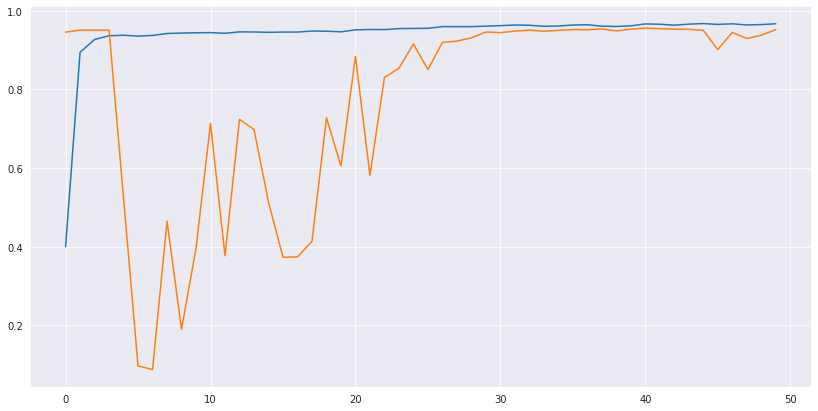

In [ ]:
# Отобразим график обучения модели
plt.figure(figsize=(14,7))
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.show()

Видно пилообразный график обучения, понизим скорость обучения, уменьшим размер батч сайза, увеличим число эпох

In [ ]:
modelUnet.compile(optimizer=Adam(lr=0.5e-3),
                loss='categorical_crossentropy',
                metrics=[dice_coef])
history = modelUnet.fit(x_train, y_train, epochs=70, batch_size=16, validation_data=(x_val, y_val))

Epoch 1/70
27/27 [==============================] - 18s 589ms/step - loss: 0.0610 - dice_coef: 0.9730 - val_loss: 0.1635 - val_dice_coef: 0.9570
Epoch 2/70
27/27 [==============================] - 16s 595ms/step - loss: 0.0555 - dice_coef: 0.9752 - val_loss: 0.2121 - val_dice_coef: 0.9546
Epoch 3/70
27/27 [==============================] - 16s 589ms/step - loss: 0.0504 - dice_coef: 0.9770 - val_loss: 0.1369 - val_dice_coef: 0.9581
Epoch 4/70
27/27 [==============================] - 15s 577ms/step - loss: 0.0525 - dice_coef: 0.9757 - val_loss: 0.1374 - val_dice_coef: 0.9601
Epoch 5/70
27/27 [==============================] - 15s 574ms/step - loss: 0.0503 - dice_coef: 0.9768 - val_loss: 0.2478 - val_dice_coef: 0.9549
Epoch 6/70
27/27 [==============================] - 16s 579ms/step - loss: 0.0466 - dice_coef: 0.9787 - val_loss: 0.2764 - val_dice_coef: 0.9544
Epoch 7/70
27/27 [==============================] - 16s 582ms/step - loss: 0.0459 - dice_coef: 0.9794 - val_loss: 0.1499 - val_dic

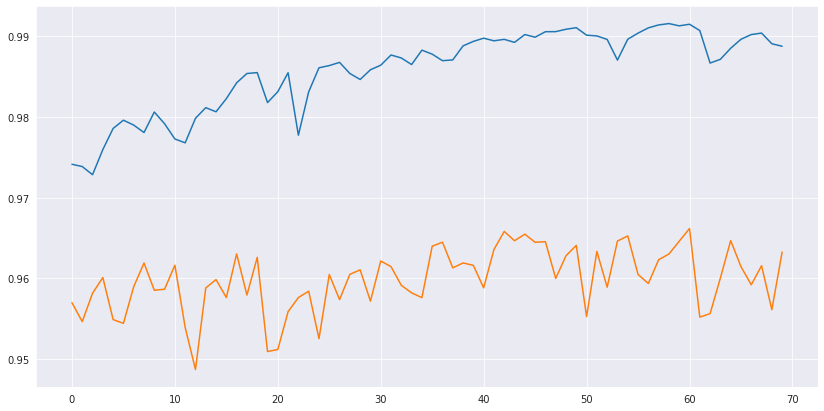

In [ ]:
# Отобразим график обучения модели
plt.figure(figsize=(14,7))
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.show()

Понизим скорость обучения, увеличим число эпох

In [ ]:
modelUnet.compile(optimizer=Adam(lr=1e-4),
                loss='categorical_crossentropy',
                metrics=[dice_coef])
history = modelUnet.fit(x_train, y_train, epochs=90, batch_size=16, validation_data=(x_val, y_val))

Epoch 1/90
27/27 [==============================] - 18s 592ms/step - loss: 0.0224 - dice_coef: 0.9903 - val_loss: 0.1885 - val_dice_coef: 0.9647
Epoch 2/90
27/27 [==============================] - 16s 584ms/step - loss: 0.0198 - dice_coef: 0.9915 - val_loss: 0.1856 - val_dice_coef: 0.9655
Epoch 3/90
27/27 [==============================] - 16s 585ms/step - loss: 0.0198 - dice_coef: 0.9916 - val_loss: 0.1822 - val_dice_coef: 0.9658
Epoch 4/90
27/27 [==============================] - 16s 582ms/step - loss: 0.0179 - dice_coef: 0.9924 - val_loss: 0.1824 - val_dice_coef: 0.9662
Epoch 5/90
27/27 [==============================] - 16s 581ms/step - loss: 0.0187 - dice_coef: 0.9921 - val_loss: 0.1950 - val_dice_coef: 0.9660
Epoch 6/90
27/27 [==============================] - 16s 582ms/step - loss: 0.0189 - dice_coef: 0.9921 - val_loss: 0.2041 - val_dice_coef: 0.9657
Epoch 7/90
27/27 [==============================] - 16s 588ms/step - loss: 0.0190 - dice_coef: 0.9920 - val_loss: 0.2197 - val_dic

In [ ]:
# modelUnet.save_weights('/content/drive/MyDrive/Brain_CT_labeling/modelUnet.h5')

In [ ]:
modelUnet = unet(num_classes, (img_width, img_height, 1)) # Создаем модель unet
modelUnet.load_weights('/content/drive/MyDrive/Brain_CT_labeling/modelUnet.h5')

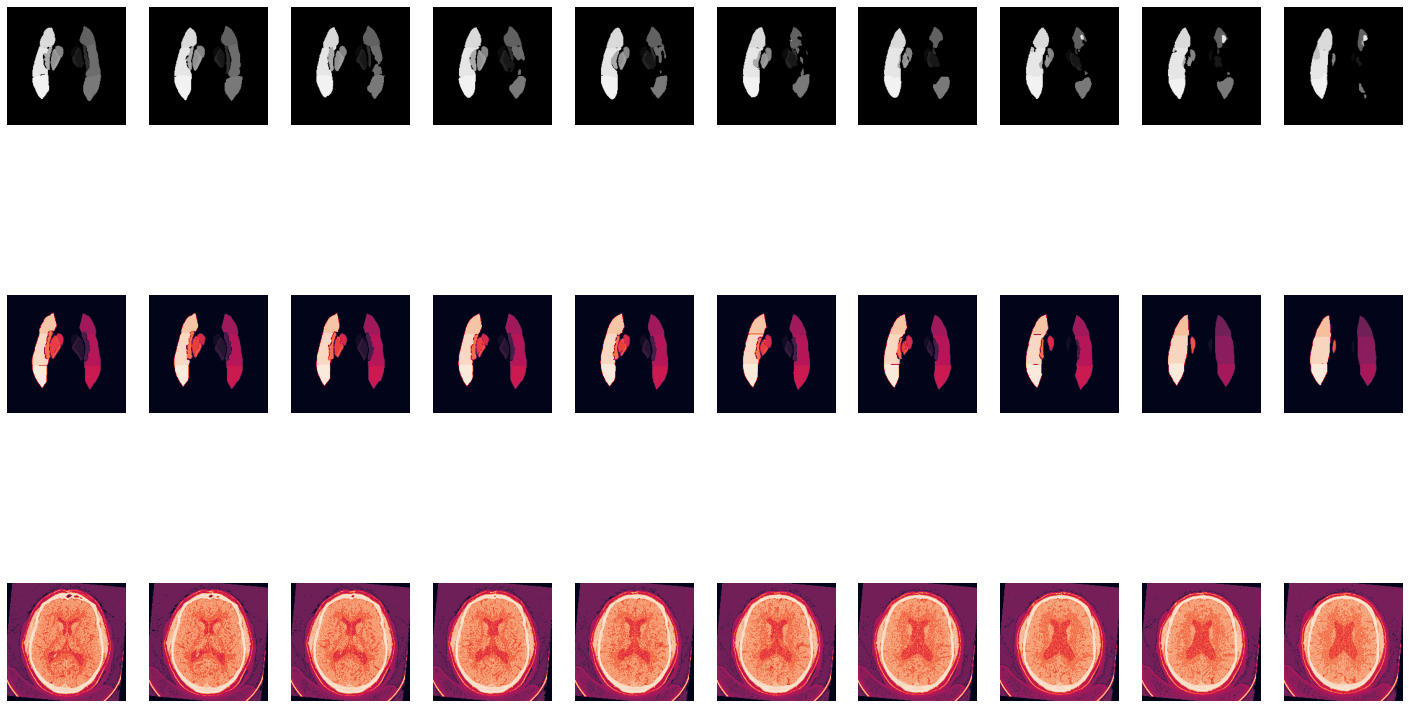

In [ ]:
processImage(modelUnet, x_val, 50, 60, 10, num_classes)

По полученным результатам видно, что не все классы нейросеть научилась распознавать, это видно и по точности на проверочной выборке (0.9652), попробуем усложнить архитектуру сети (увеличить количество блоков сверток)

### Расширенная U-net

In [ ]:
def unet_extended(num_classes=21, input_shape=(192, 192, 1)):
  '''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
  '''
  img_input = Input(input_shape)                                      # Создаем входной слой с размерностью input_shape

  # Block 1
  x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 64-нейронами
  x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
  x = Activation('relu')(x)                                           # Добавляем слой Activation

  x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)      # Добавляем Conv2D-слой с 64-нейронами
  x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
  block_1_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_1_out
  
  block_1_out_mask = Conv2D(64, (1, 1), padding='same')(block_1_out)  # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_1_out_mask

  x = MaxPooling2D()(block_1_out) # Добавляем слой MaxPooling2D

  # Block 2
  x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)     # Добавляем Conv2D-слой с 128-нейронами
  x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
  x = Activation('relu')(x) # Добавляем слой Activation

  x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)     # Добавляем Conv2D-слой с 128-нейронами
  x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
  block_2_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_2_out

  block_2_out_mask = Conv2D(128, (1, 1), padding='same')(block_2_out) # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_2_out_mask
  
  x = MaxPooling2D()(block_2_out)                                     # Добавляем слой MaxPooling2D

  # Block 3
  x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)     # Добавляем Conv2D-слой с 256-нейронами
  x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
  x = Activation('relu')(x)                                           # Добавляем слой Activation

  x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)     # Добавляем Conv2D-слой с 256-нейронами
  x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
  x = Activation('relu')(x)                                           # Добавляем слой Activation

  x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)     # Добавляем Conv2D-слой с 256-нейронами
  x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
  block_3_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_3_out

  block_3_out_mask = Conv2D(256, (1, 1), padding='same')(block_3_out) # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_3_out_mask
      
  x = MaxPooling2D()(block_3_out)                                     # Добавляем слой MaxPooling2D

    # Block 4
  x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)     # Добавляем Conv2D-слой с 512-нейронами
  x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
  x = Activation('relu')(x)                                           # Добавляем слой Activation

  x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)     # Добавляем Conv2D-слой с 256-нейронами
  x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
  x = Activation('relu')(x)                                           # Добавляем слой Activation

  x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)     # Добавляем Conv2D-слой с 256-нейронами
  x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
  block_4_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_4_out

  block_4_out_mask = Conv2D(512, (1, 1), padding='same')(block_4_out) # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_4_out_mask
          
  x = MaxPooling2D()(block_4_out)                                     # Добавляем слой MaxPooling2D

  # Block 5
  x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)     # Добавляем Conv2D-слой с 512-нейронами
  x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
  x = Activation('relu')(x)                                           # Добавляем слой Activation

  x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)     # Добавляем Conv2D-слой с 512-нейронами
  x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
  x = Activation('relu')(x)                                           # Добавляем слой Activation

  x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)     # Добавляем Conv2D-слой с 512-нейронами
  x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
  x = Activation('relu')(x)                                           # Добавляем слой Activation
  
  for_pretrained_weight = MaxPooling2D()(x)                           # Добавляем слой MaxPooling2D

  # UP 1
  x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 512 нейронами
  x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
  x = Activation('relu')(x)                                           # Добавляем слой Activation

  x = concatenate([x, block_4_out, block_4_out_mask])                 # Объединем текущий слой со слоем block_4_out и слоем-маской block_4_out_mask
  x = Conv2D(512, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 512 нейронами
  x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
  x = Activation('relu')(x)                                           # Добавляем слой Activation

  x = Conv2D(512, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 512 нейронами
  x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
  x = Activation('relu')(x)                                           # Добавляем слой Activation

  # UP 2
  x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 256 нейронами
  x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
  x = Activation('relu')(x)                                           # Добавляем слой Activation

  x = concatenate([x, block_3_out, block_3_out_mask])                 # Объединем текущий слой со слоем block_3_out и слоем-маской block_3_out_mask
  x = Conv2D(256, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 256 нейронами
  x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
  x = Activation('relu')(x)                                           # Добавляем слой Activation

  x = Conv2D(256, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 256 нейронами
  x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
  x = Activation('relu')(x)                                           # Добавляем слой Activation

  # UP 3
  x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 128 нейронами
  x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
  x = Activation('relu')(x)                                           # Добавляем слой Activation

  x = concatenate([x, block_2_out, block_2_out_mask])                 # Объединем текущий слой со слоем block_2_out и слоем-маской block_2_out_mask
  x = Conv2D(128, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
  x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
  x = Activation('relu')(x)                                           # Добавляем слой Activation

  x = Conv2D(128, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
  x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
  x = Activation('relu')(x)                                           # Добавляем слой Activation

  # UP 4
  x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 64 нейронами
  x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
  x = Activation('relu')(x)                                          # Добавляем слой Activation

  x = concatenate([x, block_1_out, block_1_out_mask])                # Объединем текущий слой со слоем block_1_out и слоем-маской block_1_out_mask
  x = Conv2D(64, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
  x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
  x = Activation('relu')(x)                                          # Добавляем слой Activation

  x = Conv2D(64, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
  x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
  x = Activation('relu')(x)                                          # Добавляем слой Activation

  x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x) # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

  model = Model(img_input, x)                                        # Создаем модель с входом 'img_input' и выходом 'x'

  # Компилируем модель 
  model.compile(optimizer=Adam(),
                loss='categorical_crossentropy',
                metrics=[dice_coef])
  
  return model                                                       # Возвращаем сформированную модель

In [ ]:
modelM3 = unet_extended(num_classes, (img_width, img_height,1))

In [ ]:
history = modelM3.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_val, y_val)) #  Обучаем модель на выборке по трем классам на полноразмерных изображениях

Epoch 1/50
14/14 [==============================] - 34s 2s/step - loss: 1.8787 - dice_coef: 0.2964 - val_loss: 1513059.5000 - val_dice_coef: 0.9450
Epoch 2/50
14/14 [==============================] - 21s 2s/step - loss: 0.2680 - dice_coef: 0.9052 - val_loss: 1782797.3750 - val_dice_coef: 0.9477
Epoch 3/50
14/14 [==============================] - 21s 2s/step - loss: 0.2260 - dice_coef: 0.9193 - val_loss: 409789.5312 - val_dice_coef: 0.9480
Epoch 4/50
14/14 [==============================] - 21s 2s/step - loss: 0.2094 - dice_coef: 0.9293 - val_loss: 33549.8828 - val_dice_coef: 0.9480
Epoch 5/50
14/14 [==============================] - 22s 2s/step - loss: 0.2132 - dice_coef: 0.9255 - val_loss: 3752.4202 - val_dice_coef: 0.9473
Epoch 6/50
14/14 [==============================] - 21s 2s/step - loss: 0.1724 - dice_coef: 0.9442 - val_loss: 1112.8993 - val_dice_coef: 0.9505
Epoch 7/50
14/14 [==============================] - 21s 2s/step - loss: 0.1791 - dice_coef: 0.9390 - val_loss: 251.9043 -

In [ ]:
# Отобразим график обучения модели
plt.figure(figsize=(14,7))
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.show()

In [ ]:
modelM3.compile(optimizer=Adam(lr=0.5e-3),
                loss='categorical_crossentropy',
                metrics=[dice_coef])
history = modelM3.fit(x_train, y_train, epochs=70, batch_size=16, validation_data=(x_val, y_val))

Epoch 1/70
27/27 [==============================] - 23s 711ms/step - loss: 0.0823 - dice_coef: 0.9636 - val_loss: 0.2473 - val_dice_coef: 0.9135
Epoch 2/70
27/27 [==============================] - 19s 703ms/step - loss: 0.0875 - dice_coef: 0.9585 - val_loss: 0.1318 - val_dice_coef: 0.9527
Epoch 3/70
27/27 [==============================] - 19s 710ms/step - loss: 0.0675 - dice_coef: 0.9679 - val_loss: 0.1140 - val_dice_coef: 0.9576
Epoch 4/70
27/27 [==============================] - 19s 720ms/step - loss: 0.0683 - dice_coef: 0.9684 - val_loss: 0.1100 - val_dice_coef: 0.9587
Epoch 5/70
27/27 [==============================] - 20s 732ms/step - loss: 0.0633 - dice_coef: 0.9699 - val_loss: 0.1054 - val_dice_coef: 0.9623
Epoch 6/70
27/27 [==============================] - 20s 741ms/step - loss: 0.0590 - dice_coef: 0.9715 - val_loss: 0.1387 - val_dice_coef: 0.9605
Epoch 7/70
27/27 [==============================] - 20s 750ms/step - loss: 0.0638 - dice_coef: 0.9711 - val_loss: 0.1536 - val_dic

***Видим, что точность на проверочной выборке чуть чуть выше, (~0.97), теперь выделим часть проверочных изображений под тестовую выборку.***

# Создание x_train, y_train, x_val, y_val, x_test, y_test

в обучающую выборку пойдут 4 изображения, 

в проверочную выборку - 1

в тестовую - 1

In [ ]:
# предварительно разобьем каждое изображение послойно вдоль оси Z, то есть 
# например из первого 3d изображения размером 116 * img_height * img_width 
# получим 116 изображений размером img_height * img_width * 1

x_train = get_final_array(prepared_orig_images, 0, 3)
x_val = get_final_array(prepared_orig_images, 4, 4)
x_test = get_final_array(prepared_orig_images, 5, 5)

Форма полученного массива =  (422, 192, 192, 1)
Форма полученного массива =  (106, 192, 192, 1)
Форма полученного массива =  (102, 192, 192, 1)
Форма полученного обучающего массива =    (422, 192, 192, 1)
Форма полученного проверочного массива =  (106, 192, 192, 1)
Форма полученного контрольного массива =  (102, 192, 192, 1)


In [ ]:
np.save('/content/drive/MyDrive/Brain_CT_labeling/x_train.npy', x_train)
np.save('/content/drive/MyDrive/Brain_CT_labeling/x_val.npy', x_val)
np.save('/content/drive/MyDrive/Brain_CT_labeling/x_test.npy', x_test)

In [ ]:
# в таком же соотношении создадим y_train и y_val
y_train_no_OHE = get_final_array(prepared_seg_images, 0, 3, uint_flag=True)
y_val_no_OHE = get_final_array(prepared_seg_images, 4, 4, uint_flag=True)
y_test_no_OHE = get_final_array(prepared_seg_images, 5, 5, uint_flag=True)

Форма полученного массива =  (422, 192, 192, 1)
Форма полученного массива =  (106, 192, 192, 1)
Форма полученного массива =  (102, 192, 192, 1)


In [ ]:
# Теперь преобразуем в формат one-hot-encoding все y-массивы
cur_time = time.time()
y_train = color_2_OHE(y_train_no_OHE)
print('Затраченное время ', round((time.time()- cur_time), 1), ' секунд')
# np.save('/content/drive/MyDrive/Brain_CT_labeling/y_train.npy', y_train)

Сформированно 25 из 422 слоёв 	 осталось: 397
Сформированно 50 из 422 слоёв 	 осталось: 372
Сформированно 75 из 422 слоёв 	 осталось: 347
Сформированно 100 из 422 слоёв 	 осталось: 322
Сформированно 125 из 422 слоёв 	 осталось: 297
Сформированно 150 из 422 слоёв 	 осталось: 272
Сформированно 175 из 422 слоёв 	 осталось: 247
Сформированно 200 из 422 слоёв 	 осталось: 222
Сформированно 225 из 422 слоёв 	 осталось: 197
Сформированно 250 из 422 слоёв 	 осталось: 172
Сформированно 275 из 422 слоёв 	 осталось: 147
Сформированно 300 из 422 слоёв 	 осталось: 122
Сформированно 325 из 422 слоёв 	 осталось: 97
Сформированно 350 из 422 слоёв 	 осталось: 72
Сформированно 375 из 422 слоёв 	 осталось: 47
Сформированно 400 из 422 слоёв 	 осталось: 22
Затраченное время  102.8  секунд


In [ ]:
cur_time = time.time()
y_val = color_2_OHE(y_val_no_OHE)
print('Затраченное время ', round((time.time()- cur_time), 1), ' секунд')
# np.save('/content/drive/MyDrive/Brain_CT_labeling/y_val.npy', y_val)

Сформированно 25 из 106 слоёв 	 осталось: 81
Сформированно 50 из 106 слоёв 	 осталось: 56
Сформированно 75 из 106 слоёв 	 осталось: 31
Сформированно 100 из 106 слоёв 	 осталось: 6
Затраченное время  27.4  секунд


In [ ]:
cur_time = time.time()
y_test = color_2_OHE(y_test_no_OHE)
print('Затраченное время ', round((time.time()- cur_time), 1), ' секунд')
# np.save('/content/drive/MyDrive/Brain_CT_labeling/y_test.npy', y_test)

Сформированно 25 из 102 слоёв 	 осталось: 77
Сформированно 50 из 102 слоёв 	 осталось: 52
Сформированно 75 из 102 слоёв 	 осталось: 27
Сформированно 100 из 102 слоёв 	 осталось: 2
Затраченное время  25.2  секунд


### Подгружаем созданные массивы

In [ ]:
x_train = np.load('/content/drive/MyDrive/Brain_CT_labeling/x_train.npy')
x_val = np.load('/content/drive/MyDrive/Brain_CT_labeling/x_val.npy')
x_test = np.load('/content/drive/MyDrive/Brain_CT_labeling/x_test.npy')

y_train = np.load('/content/drive/MyDrive/Brain_CT_labeling/y_train.npy')
y_val = np.load('/content/drive/MyDrive/Brain_CT_labeling/y_val.npy')
y_test = np.load('/content/drive/MyDrive/Brain_CT_labeling/y_test.npy')

# Финальная сеть
Создадим расширенную U-net сеть, но обучим уже с использованием тренировочной (та же что и в предыдущем варианте, 4 исходных изображения), проверочной (1 изображение) и тестовой (одно изображение которая сеть не видела совсем) выборок

In [ ]:
modelM3 = unet_extended(num_classes, (img_width, img_height,1))

In [ ]:
history = modelM3.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_val, y_val)) #  Обучаем модель на выборке по трем классам на полноразмерных изображениях

Epoch 1/50
14/14 [==============================] - 38s 2s/step - loss: 2.0444 - dice_coef: 0.2760 - val_loss: 2914225.2500 - val_dice_coef: 0.9526
Epoch 2/50
14/14 [==============================] - 17s 1s/step - loss: 0.2740 - dice_coef: 0.9021 - val_loss: 1069751.7500 - val_dice_coef: 0.9552
Epoch 3/50
14/14 [==============================] - 17s 1s/step - loss: 0.2391 - dice_coef: 0.9212 - val_loss: 106482.3516 - val_dice_coef: 0.9552
Epoch 4/50
14/14 [==============================] - 17s 1s/step - loss: 0.2142 - dice_coef: 0.9247 - val_loss: 14491.5781 - val_dice_coef: 0.9552
Epoch 5/50
14/14 [==============================] - 17s 1s/step - loss: 0.2422 - dice_coef: 0.9118 - val_loss: 3542.3167 - val_dice_coef: 0.9549
Epoch 6/50
14/14 [==============================] - 17s 1s/step - loss: 0.2388 - dice_coef: 0.9226 - val_loss: 830.8274 - val_dice_coef: 0.9549
Epoch 7/50
14/14 [==============================] - 17s 1s/step - loss: 0.2049 - dice_coef: 0.9315 - val_loss: 456.5556 - 

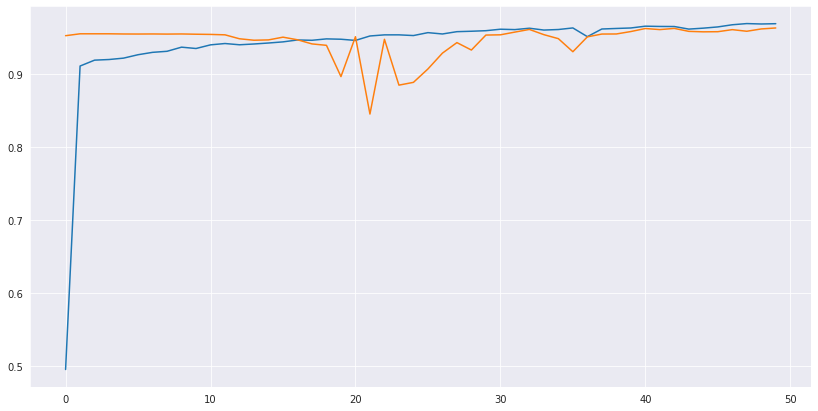

In [ ]:
# Отобразим график обучения модели
plt.figure(figsize=(14,7))
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.show()

In [ ]:
modelM3.compile(optimizer=Adam(lr=0.5e-3),
                loss='categorical_crossentropy',
                metrics=[dice_coef])
history = modelM3.fit(x_train, y_train, epochs=70, batch_size=16, validation_data=(x_val, y_val))

Epoch 1/70
27/27 [==============================] - 26s 693ms/step - loss: 0.0717 - dice_coef: 0.9673 - val_loss: 0.2256 - val_dice_coef: 0.9391
Epoch 2/70
27/27 [==============================] - 18s 678ms/step - loss: 0.0726 - dice_coef: 0.9646 - val_loss: 0.1416 - val_dice_coef: 0.9570
Epoch 3/70
27/27 [==============================] - 18s 675ms/step - loss: 0.0659 - dice_coef: 0.9687 - val_loss: 0.1719 - val_dice_coef: 0.9508
Epoch 4/70
27/27 [==============================] - 18s 675ms/step - loss: 0.0630 - dice_coef: 0.9696 - val_loss: 0.3414 - val_dice_coef: 0.8963
Epoch 5/70
27/27 [==============================] - 18s 675ms/step - loss: 0.0702 - dice_coef: 0.9666 - val_loss: 0.2581 - val_dice_coef: 0.9479
Epoch 6/70
27/27 [==============================] - 18s 676ms/step - loss: 0.0671 - dice_coef: 0.9682 - val_loss: 0.1268 - val_dice_coef: 0.9613
Epoch 7/70
27/27 [==============================] - 18s 677ms/step - loss: 0.0658 - dice_coef: 0.9698 - val_loss: 0.0959 - val_dic

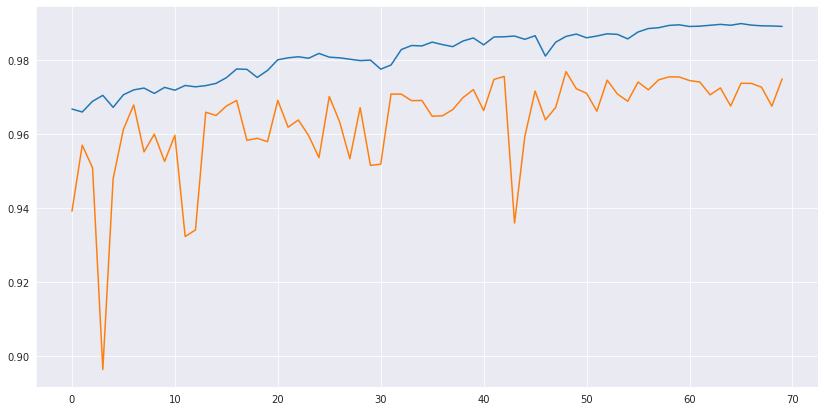

In [ ]:
# Отобразим график обучения модели
plt.figure(figsize=(14,7))
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.show()

In [ ]:
modelM3.compile(optimizer=Adam(lr=1e-4),
                loss='categorical_crossentropy',
                metrics=[dice_coef])
history = modelM3.fit(x_train, y_train, epochs=90, batch_size=16, validation_data=(x_val, y_val))

Epoch 1/90
27/27 [==============================] - 21s 693ms/step - loss: 0.0244 - dice_coef: 0.9896 - val_loss: 0.1293 - val_dice_coef: 0.9698
Epoch 2/90
27/27 [==============================] - 18s 674ms/step - loss: 0.0226 - dice_coef: 0.9904 - val_loss: 0.0956 - val_dice_coef: 0.9759
Epoch 3/90
27/27 [==============================] - 18s 674ms/step - loss: 0.0215 - dice_coef: 0.9910 - val_loss: 0.0930 - val_dice_coef: 0.9755
Epoch 4/90
27/27 [==============================] - 18s 675ms/step - loss: 0.0214 - dice_coef: 0.9909 - val_loss: 0.1002 - val_dice_coef: 0.9747
Epoch 5/90
27/27 [==============================] - 18s 675ms/step - loss: 0.0212 - dice_coef: 0.9911 - val_loss: 0.0918 - val_dice_coef: 0.9762
Epoch 6/90
27/27 [==============================] - 18s 677ms/step - loss: 0.0234 - dice_coef: 0.9901 - val_loss: 0.0953 - val_dice_coef: 0.9759
Epoch 7/90
27/27 [==============================] - 18s 676ms/step - loss: 0.0194 - dice_coef: 0.9918 - val_loss: 0.0921 - val_dic

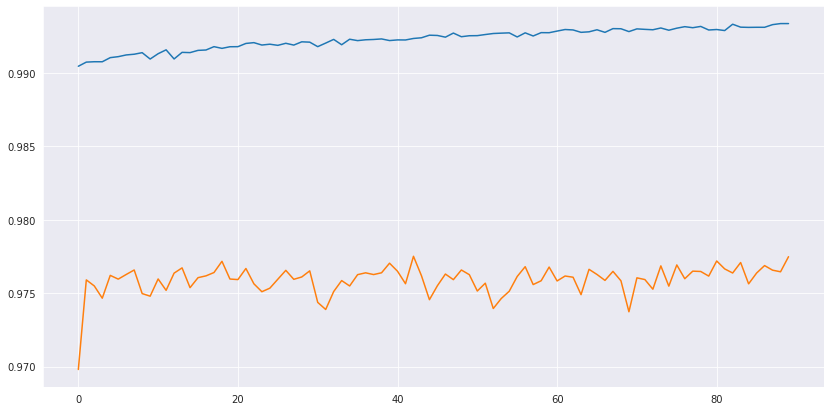

In [ ]:
# Отобразим график обучения модели
plt.figure(figsize=(14,7))
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.show()

In [ ]:
# modelM3.save_weights('/content/drive/MyDrive/Brain_CT_labeling/modelM3_final_lr_1e-4_with_x_test.h5')

поменяем скорость обучения

In [ ]:
modelM3.compile(optimizer=Adam(lr=0.8e-4),
                loss='categorical_crossentropy',
                metrics=[dice_coef])
history = modelM3.fit(x_train, y_train, epochs=90, batch_size=16, validation_data=(x_val, y_val))

Epoch 1/90
27/27 [==============================] - 21s 692ms/step - loss: 0.0165 - dice_coef: 0.9932 - val_loss: 0.1314 - val_dice_coef: 0.9773
Epoch 2/90
27/27 [==============================] - 18s 674ms/step - loss: 0.0161 - dice_coef: 0.9933 - val_loss: 0.1434 - val_dice_coef: 0.9757
Epoch 3/90
27/27 [==============================] - 18s 675ms/step - loss: 0.0161 - dice_coef: 0.9934 - val_loss: 0.1330 - val_dice_coef: 0.9771
Epoch 4/90
27/27 [==============================] - 18s 676ms/step - loss: 0.0156 - dice_coef: 0.9935 - val_loss: 0.1462 - val_dice_coef: 0.9759
Epoch 5/90
27/27 [==============================] - 18s 676ms/step - loss: 0.0143 - dice_coef: 0.9941 - val_loss: 0.1394 - val_dice_coef: 0.9765
Epoch 6/90
27/27 [==============================] - 18s 676ms/step - loss: 0.0169 - dice_coef: 0.9929 - val_loss: 0.1372 - val_dice_coef: 0.9768
Epoch 7/90
27/27 [==============================] - 18s 677ms/step - loss: 0.0157 - dice_coef: 0.9935 - val_loss: 0.1438 - val_dic

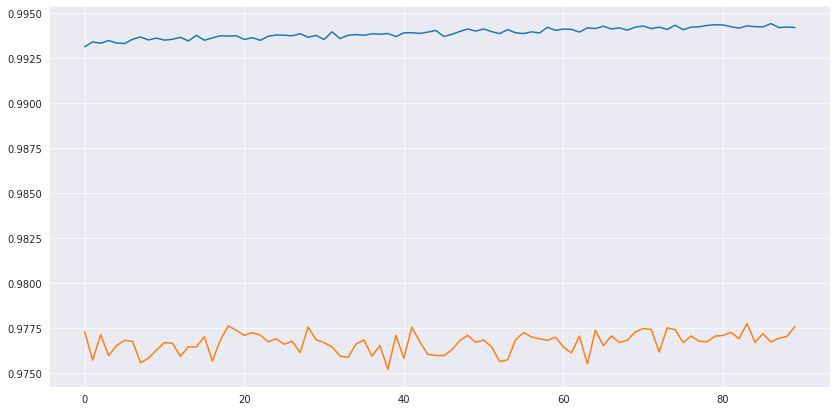

In [ ]:
# Отобразим график обучения модели
plt.figure(figsize=(14,7))
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.show()

In [ ]:
# modelM3.save_weights('/content/drive/MyDrive/Brain_CT_labeling/modelM3_final_lr_08e-4_with_x_test.h5')

In [ ]:
modelM3 = unet_extended(num_classes, (img_width, img_height,1))
modelM3.load_weights('/content/drive/MyDrive/Brain_CT_labeling/modelM3_final_lr_08e-4_with_x_test.h5')

In [ ]:
modelM3.compile(optimizer=Adam(lr=2e-5),
                loss='categorical_crossentropy',
                metrics=[dice_coef])
history = modelM3.fit(x_train, y_train, epochs=200, batch_size=16, validation_data=(x_val, y_val))

Epoch 1/200
27/27 [==============================] - 36s 835ms/step - loss: 0.0131 - dice_coef: 0.9946 - val_loss: 0.1691 - val_dice_coef: 0.9773
Epoch 2/200
27/27 [==============================] - 18s 661ms/step - loss: 0.0132 - dice_coef: 0.9945 - val_loss: 0.1681 - val_dice_coef: 0.9771
Epoch 3/200
27/27 [==============================] - 18s 671ms/step - loss: 0.0132 - dice_coef: 0.9945 - val_loss: 0.1725 - val_dice_coef: 0.9768
Epoch 4/200
27/27 [==============================] - 18s 685ms/step - loss: 0.0119 - dice_coef: 0.9950 - val_loss: 0.1678 - val_dice_coef: 0.9770
Epoch 5/200
27/27 [==============================] - 19s 694ms/step - loss: 0.0145 - dice_coef: 0.9939 - val_loss: 0.1738 - val_dice_coef: 0.9764
Epoch 6/200
27/27 [==============================] - 18s 686ms/step - loss: 0.0116 - dice_coef: 0.9951 - val_loss: 0.1742 - val_dice_coef: 0.9767
Epoch 7/200
27/27 [==============================] - 18s 681ms/step - loss: 0.0128 - dice_coef: 0.9946 - val_loss: 0.1685 - 

In [ ]:
# modelM3.save_weights('/content/drive/MyDrive/Brain_CT_labeling/modelM3_final_lr_08e-4_with_x_test_200_epochs.h5')

In [ ]:
modelM3.compile(optimizer=Adam(lr=5e-6),
                loss='categorical_crossentropy',
                metrics=[dice_coef])
history = modelM3.fit(x_train, y_train, epochs=1000, batch_size=16, validation_data=(x_val, y_val))

Epoch 1/1000
27/27 [==============================] - 21s 701ms/step - loss: 0.0119 - dice_coef: 0.9949 - val_loss: 0.2153 - val_dice_coef: 0.9767
Epoch 2/1000
27/27 [==============================] - 19s 692ms/step - loss: 0.0130 - dice_coef: 0.9945 - val_loss: 0.2153 - val_dice_coef: 0.9767
Epoch 3/1000
27/27 [==============================] - 18s 686ms/step - loss: 0.0131 - dice_coef: 0.9945 - val_loss: 0.2167 - val_dice_coef: 0.9767
Epoch 4/1000
27/27 [==============================] - 18s 686ms/step - loss: 0.0103 - dice_coef: 0.9956 - val_loss: 0.2150 - val_dice_coef: 0.9767
Epoch 5/1000
27/27 [==============================] - 18s 686ms/step - loss: 0.0119 - dice_coef: 0.9950 - val_loss: 0.2159 - val_dice_coef: 0.9766
Epoch 6/1000
27/27 [==============================] - 19s 688ms/step - loss: 0.0119 - dice_coef: 0.9950 - val_loss: 0.2166 - val_dice_coef: 0.9767
Epoch 7/1000
27/27 [==============================] - 19s 691ms/step - loss: 0.0120 - dice_coef: 0.9949 - val_loss: 0.

По точности обучения видим, что мы, судя во всему попали в локальный минимум, попробуем теперь увеличить скорость обучения

In [ ]:
# Сохраним нашу модель
# modelM3.save_weights('/content/drive/MyDrive/Brain_CT_labeling/modelM3_final_lr_5e-6_with_x_test_1000_epochs.h5')

In [ ]:
modelM3.load_weights('/content/drive/MyDrive/Brain_CT_labeling/modelM3_final_lr_5e-6_with_x_test_1000_epochs.h5')

In [ ]:
modelM3.compile(optimizer=Adam(lr=5e-5),
                loss='categorical_crossentropy',
                metrics=[dice_coef])
history = modelM3.fit(x_train, y_train, epochs=50, batch_size=16, validation_data=(x_val, y_val))

Epoch 1/50
27/27 [==============================] - 31s 893ms/step - loss: 0.0098 - dice_coef: 0.9959 - val_loss: 0.2877 - val_dice_coef: 0.9760
Epoch 2/50
27/27 [==============================] - 19s 714ms/step - loss: 0.0109 - dice_coef: 0.9954 - val_loss: 0.2762 - val_dice_coef: 0.9765
Epoch 3/50
27/27 [==============================] - 19s 702ms/step - loss: 0.0104 - dice_coef: 0.9956 - val_loss: 0.2803 - val_dice_coef: 0.9768
Epoch 4/50
27/27 [==============================] - 19s 696ms/step - loss: 0.0099 - dice_coef: 0.9958 - val_loss: 0.2730 - val_dice_coef: 0.9771
Epoch 5/50
27/27 [==============================] - 19s 692ms/step - loss: 0.0100 - dice_coef: 0.9959 - val_loss: 0.2710 - val_dice_coef: 0.9762
Epoch 6/50
27/27 [==============================] - 19s 700ms/step - loss: 0.0095 - dice_coef: 0.9960 - val_loss: 0.2625 - val_dice_coef: 0.9764
Epoch 7/50
27/27 [==============================] - 19s 697ms/step - loss: 0.0105 - dice_coef: 0.9958 - val_loss: 0.2560 - val_dic

По показателям точности видно, что это не принесло результатов, поэтому
на этом остановимся:
 
 *  0.9957 - точность на обучающей выборке,
 * 0.9761 - точность на проверочной

In [ ]:
# Сохраним нашу модель
# modelM3.save_weights('/content/drive/MyDrive/Brain_CT_labeling/modelM3_final.h5')

*Посмотрим на результаты работы нашей сети*

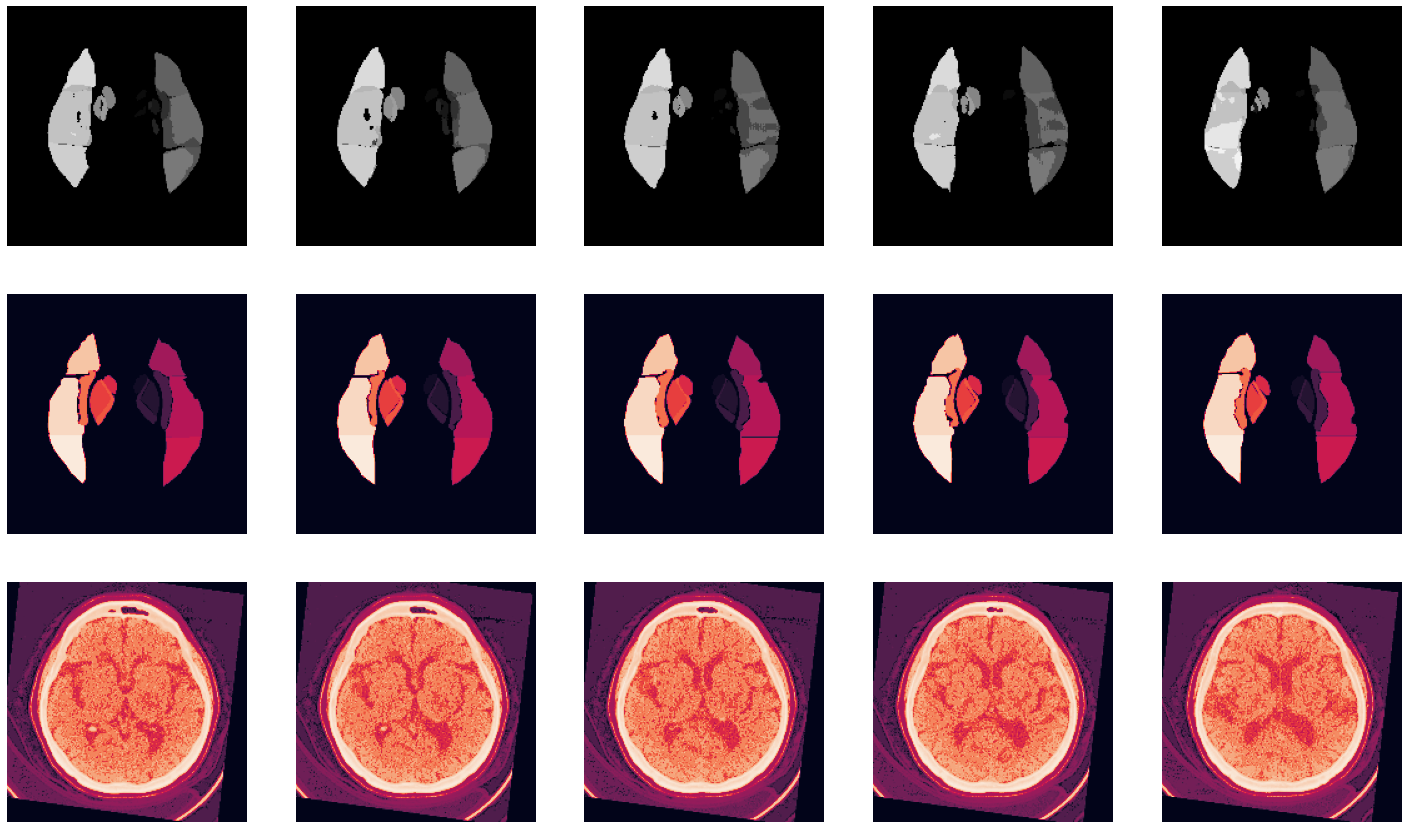

In [ ]:
processImage(modelM3, x_test, y_test, 50, 55)

По картинкам видно, что есть неточности в распознавании классов, что также видно по метрике на финальной эпохе.

In [ ]:
# Создадим папку для сохранения результатов
os.mkdir('/content/drive/MyDrive/Brain_CT_labeling/results')

In [ ]:
# сохраним изображения из обучающей выборки 
# получим список начальных и конечных индексов
first_indexes = []
for el in range(0,4):
  first_indexes.append(prepared_orig_images[el].shape[0])
first_indexes_to_slice = [sum(first_indexes) - sum(first_indexes[i:]) for i in range(4)]
last_indexes_to_slice = [sum(first_indexes) - sum(first_indexes[i:]) + first_indexes[i] for i in range(4)]
# теперь сохраним изображения по полученным индексам
for _ in range(0,4):
  save_path = f'/content/drive/MyDrive/Brain_CT_labeling/results/train_image_{_}.nii.gz'
  image = get_sitk_image(modelM3, x_train, first_indexes_to_slice[_], last_indexes_to_slice[_], save_path)
  print('Сформировано изображение следующей формы: ',sitk.GetArrayFromImage(image).shape)

Сформировано изображение следующей формы:  (116, 512, 512)
Сформировано изображение следующей формы:  (98, 512, 512)
Сформировано изображение следующей формы:  (104, 512, 512)
Сформировано изображение следующей формы:  (104, 512, 512)


In [ ]:
save_path = '/content/drive/MyDrive/Brain_CT_labeling/results/val_image.nii.gz'
image = get_sitk_image(modelM3, x_val, 0, x_val.shape[0], save_path)
print('Сформировано изображение следующей формы: ',sitk.GetArrayFromImage(image).shape)

Сформировано изображение следующей формы:  (106, 512, 512)


In [ ]:
save_path = '/content/drive/MyDrive/Brain_CT_labeling/results/test_image.nii.gz'
image = get_sitk_image(modelM3, x_test, 0, x_test.shape[0], save_path)
print('Сформировано изображение следующей формы: ',sitk.GetArrayFromImage(image).shape)

Сформировано изображение следующей формы:  (102, 512, 512)


**Выводы:**

*Допущения, принятые мной в виду ограничения по используемым вычислительным мощностям:*

  * Размер обрабатываемых изображений (можно было бы подавать на вход нейросети исходный размер картинок 512*512, вероятно это увеличило бы точность сегментации

  * Можно было использовать архитектуру, которая на вход принимает проекции с 3-х разных плоскостей (я взял только ось Z), что, вероятно, также увеличило бы конечную точность 

*Пути дальнейшей доработки:*

  * При работе с уменьшенными изображениями можно было бы использовать другой метод интерполяции в функции resize_image (я использовал interpolation=cv2.INTER_LINEAR)

  * при обработке изображений можно было бы более точно подобрать параметры увеличения контрастности, резкости, а также удалить фоновый шум, обрезать (оставить только изображение по контуру черепа)

  * также, на этапе формирования numpy массивов из изображений sitk можно было бы использовать более высокое значение параметра rescale и в последствии работать не со значениями пикселей в диапазоне 0 - 255, а, например, от 0 до 512 и выше, однако вряд ли это позволил бы сделать google.colaboratories

  * для подбора архитектуры и гиперпараметров сети можно было бы использовать генетические алгоритмы

  * в качестве сверточных слоев, вероятно, можно было бы использовать Conv3D слои, а, следовательно, обрабатывать изображения не послойно, а целиком, но опыта работы с ними у меня пока нет

  * для увеличения базы изображений можно было испльзовать аугументацию

  * для удобства тренировки сети можно было бы использовать CallBack сохранения наилучшей эпохи при обучении

  * можно было бы попробовать другие соотношения x_train/x_val/x_test, я взял 4 sitk-изображения на тренировочную и по одному на проверочную и тестовую
  
  * можно было бы использовать другие популярные архитектуры, например PSP-net, SegNET, LinkNet, или, опять же с помощью генетических алгоритмов, подобрать более "легковесную" собственную архитектуру

Выбор в пользу архитектуры U-net был сделан исходя из опыта работы с ней, а также в виду её простоты и популярности. Однако, в качестве дальнейшего развития проекта не исключаю использование и создание других архитектур.




ссылка на результаты работы (сохраненные модели, полученные sitk-изображения, выборки x_train, x_val, x_test, y_train, y_val, y_test):


https://drive.google.com/drive/folders/1ENKen8mFNWp0H8qYXSLvaSCGmaj9mmVa?usp=sharing


# Конец